## Evaluation of Models

### In this notebook, ensemble methods are built as well.

In [1]:
import torch
import torchmetrics
import sys
import os
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import MLFlowLogger

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

if project_root not in sys.path:
    sys.path.append(project_root)
    
from model_config import NUM_CLASSES    
from model_utils import PretrainedModelMobileNet, PretrainedEfficientNetV2, PretrainedModelInception, Model, ModelKANLinear, ClassificationData, no_augmentation, inception_no_augmentation

torch.cuda.empty_cache()
torch.set_float32_matmul_precision("medium")
L.seed_everything(111)

Seed set to 111


111

In [2]:
data = ClassificationData(batch_size=128, transform=no_augmentation)
mobile_net = PretrainedModelMobileNet.load_from_checkpoint("./checkpoints/mobile_net/no-augmentation_bs_64-epoch=18-val_f1_macro=0.70.ckpt", weights_only=False)
efficient_net = PretrainedEfficientNetV2.load_from_checkpoint("./checkpoints/efficientnet_v2/no-augmentation_bs-512_epoch=04-val_f1_macro=0.74.ckpt", weights_only=False)
inception = PretrainedModelInception.load_from_checkpoint("./checkpoints/inception/no_augmentation.ckpt", weights_only=False)
cnn = Model.load_from_checkpoint("./checkpoints/cnn/no-augment_run_8_lr=0.1_bs=512_wd=0.001_dropout=0.2_seed=131-epoch=06-val_f1_macro=0.60.ckpt", hyperparameters={"learning_rate": 0.1, "weight_decay": 0.001, "dropout": 0.2, "batch_size": 512}, weights_only=False)
kan_linear = ModelKANLinear.load_from_checkpoint("./checkpoints/kan-linear/no-augment_lr=0.1_bs=512_wd=0.001_dropout=0.2-epoch=04-val_f1_macro=0.60.ckpt", weights_only=False)
data.setup("test")
test_loader = data.test_dataloader()
inception_data = ClassificationData(batch_size=128, transform=inception_no_augmentation)
inception_data.setup("test")
inception_test_loader = inception_data.test_dataloader()

In [15]:
def evaluate(loaded_model, test_loader):
    loaded_model.eval()
    with torch.no_grad():
        probabilities = []
        for batch in test_loader:
            x, y = batch
            x = x.to(loaded_model.device)
            y = y.to(loaded_model.device)
            logits = loaded_model(x)
            probabilities_append = torch.softmax(logits, dim=1)
            probabilities.append(probabilities_append)
        probabilities = torch.cat(probabilities).to(loaded_model.device)
        y = torch.cat([batch[1] for batch in test_loader]).to(loaded_model.device)
        f1 = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        recall = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        precision = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(loaded_model.device)
        precision_no_avg = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        recall_no_avg = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        f1_no_avg = torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average=None).to(loaded_model.device)
        precision_recall_curve = torchmetrics.PrecisionRecallCurve(task="multiclass", num_classes=NUM_CLASSES).to(loaded_model.device)
        confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=NUM_CLASSES, task="multiclass").to(loaded_model.device)
        per_class_precision = precision_no_avg(probabilities, y)
        per_class_recall = recall_no_avg(probabilities, y)
        per_class_f1 = f1_no_avg(probabilities, y)
        precision_recall_curve.update(probabilities, y)
        f1_macro = f1(probabilities, y)
        recall_macro = recall(probabilities, y)
        precision_macro = precision(probabilities, y)
        confusion_matrix.update(probabilities, y)
        return {
            "f1_macro": f1_macro,
            "recall_macro": recall_macro,
            "precision_macro": precision_macro,
            "f1_no_avg": f1_no_avg,
            "recall_no_avg": recall_no_avg,
            "precision_no_avg": precision_no_avg,
            "per_class_precision": per_class_precision,
            "per_class_recall": per_class_recall,
            "per_class_f1": per_class_f1,
            "precision_recall_curve": precision_recall_curve,
            "confusion_matrix": confusion_matrix
        }

mobile_net_metrics = evaluate(mobile_net, test_loader)
efficient_net_metrics = evaluate(efficient_net, test_loader)
inception_metrics = evaluate(inception, inception_test_loader)
cnn_metrics = evaluate(cnn, test_loader)
kan_linear_metrics = evaluate(kan_linear, test_loader)

Macro Average Precision: 0.6967921853065491
Macro Average Recall: 0.698199987411499
Macro Average F1: 0.6940736770629883
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


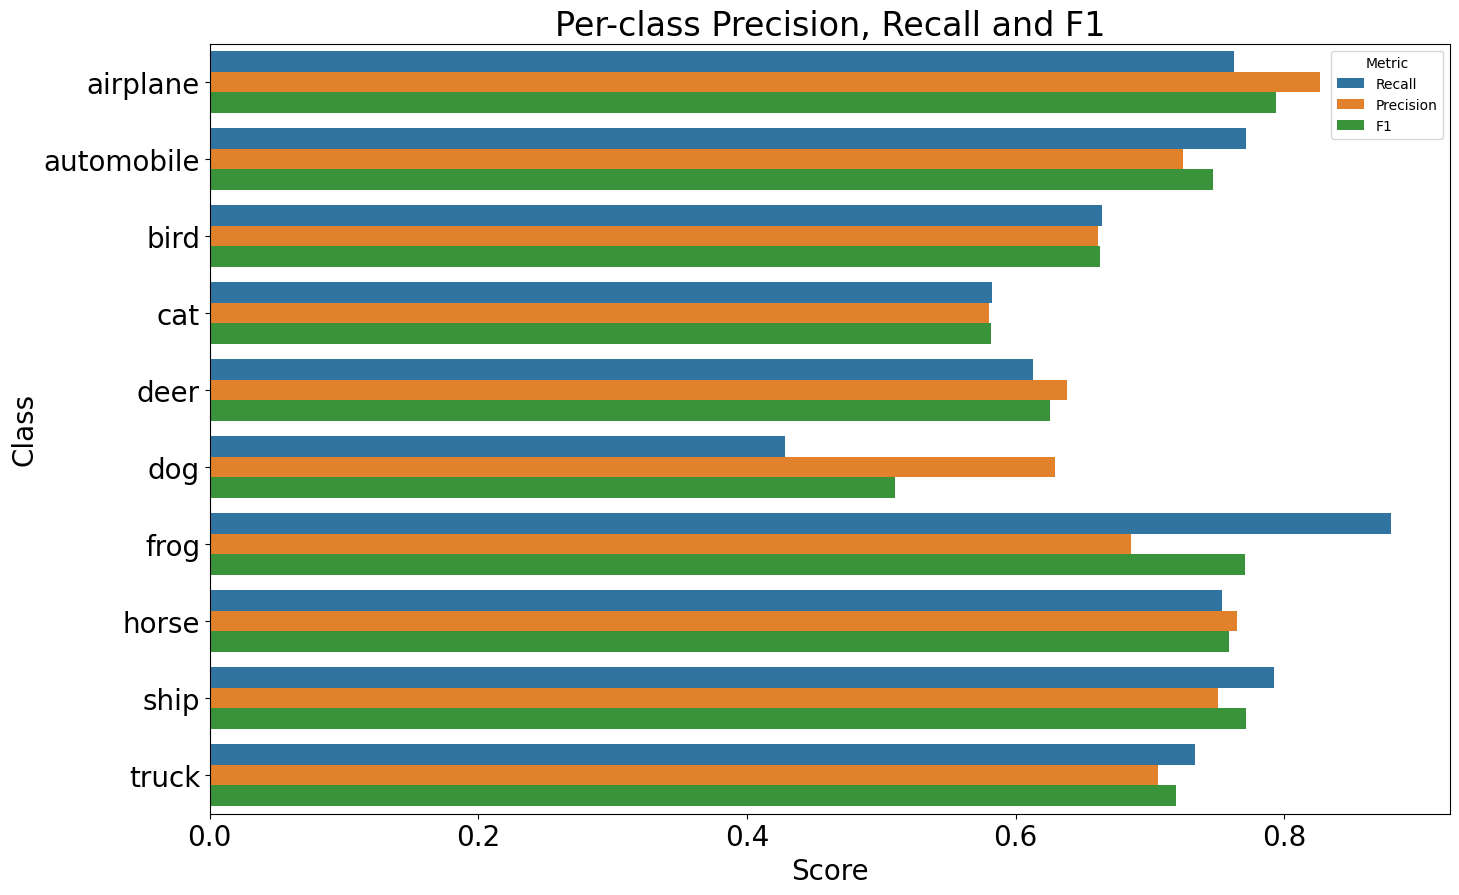

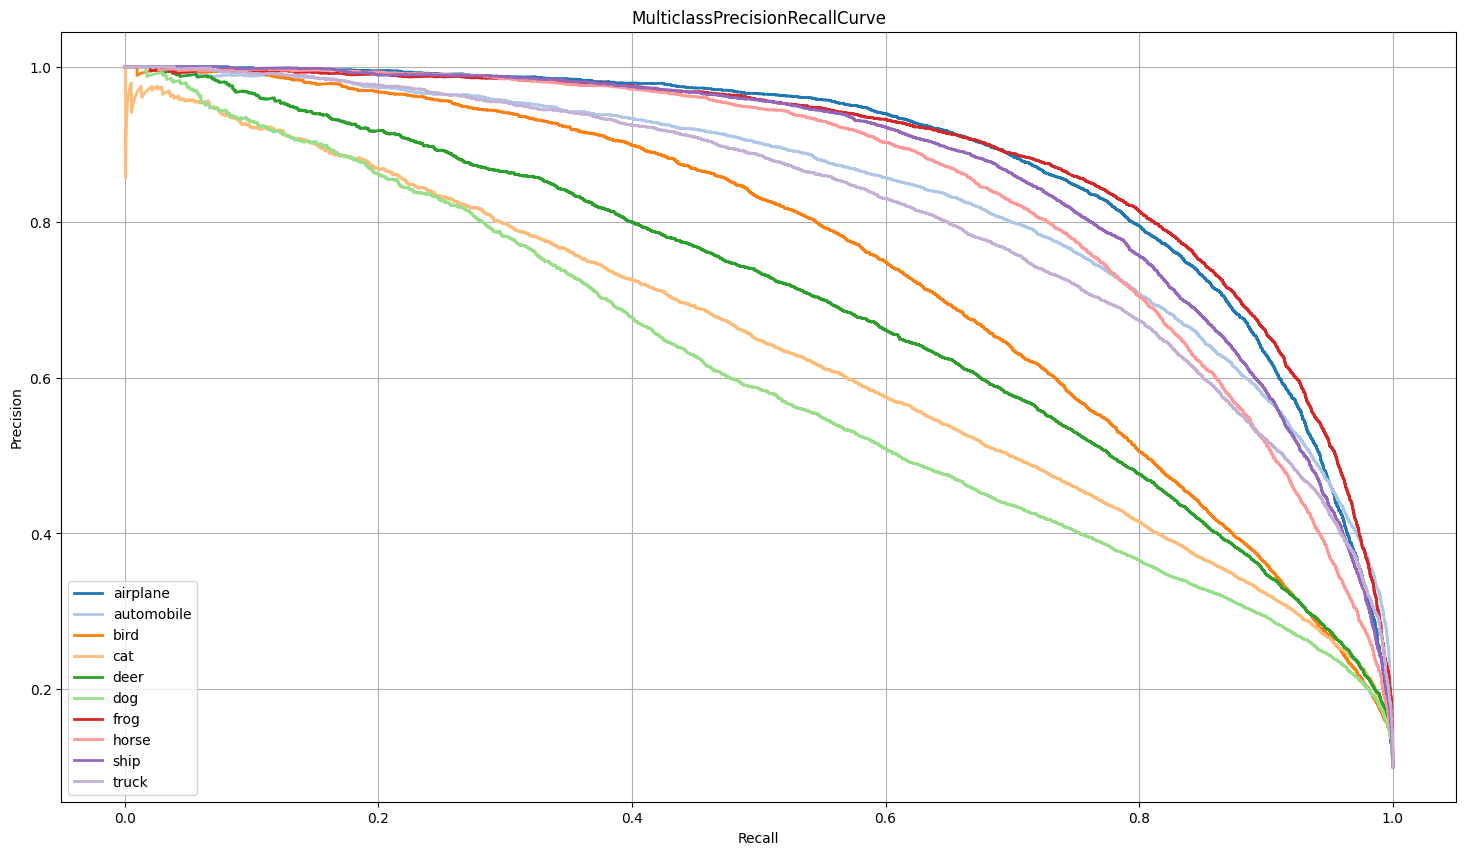

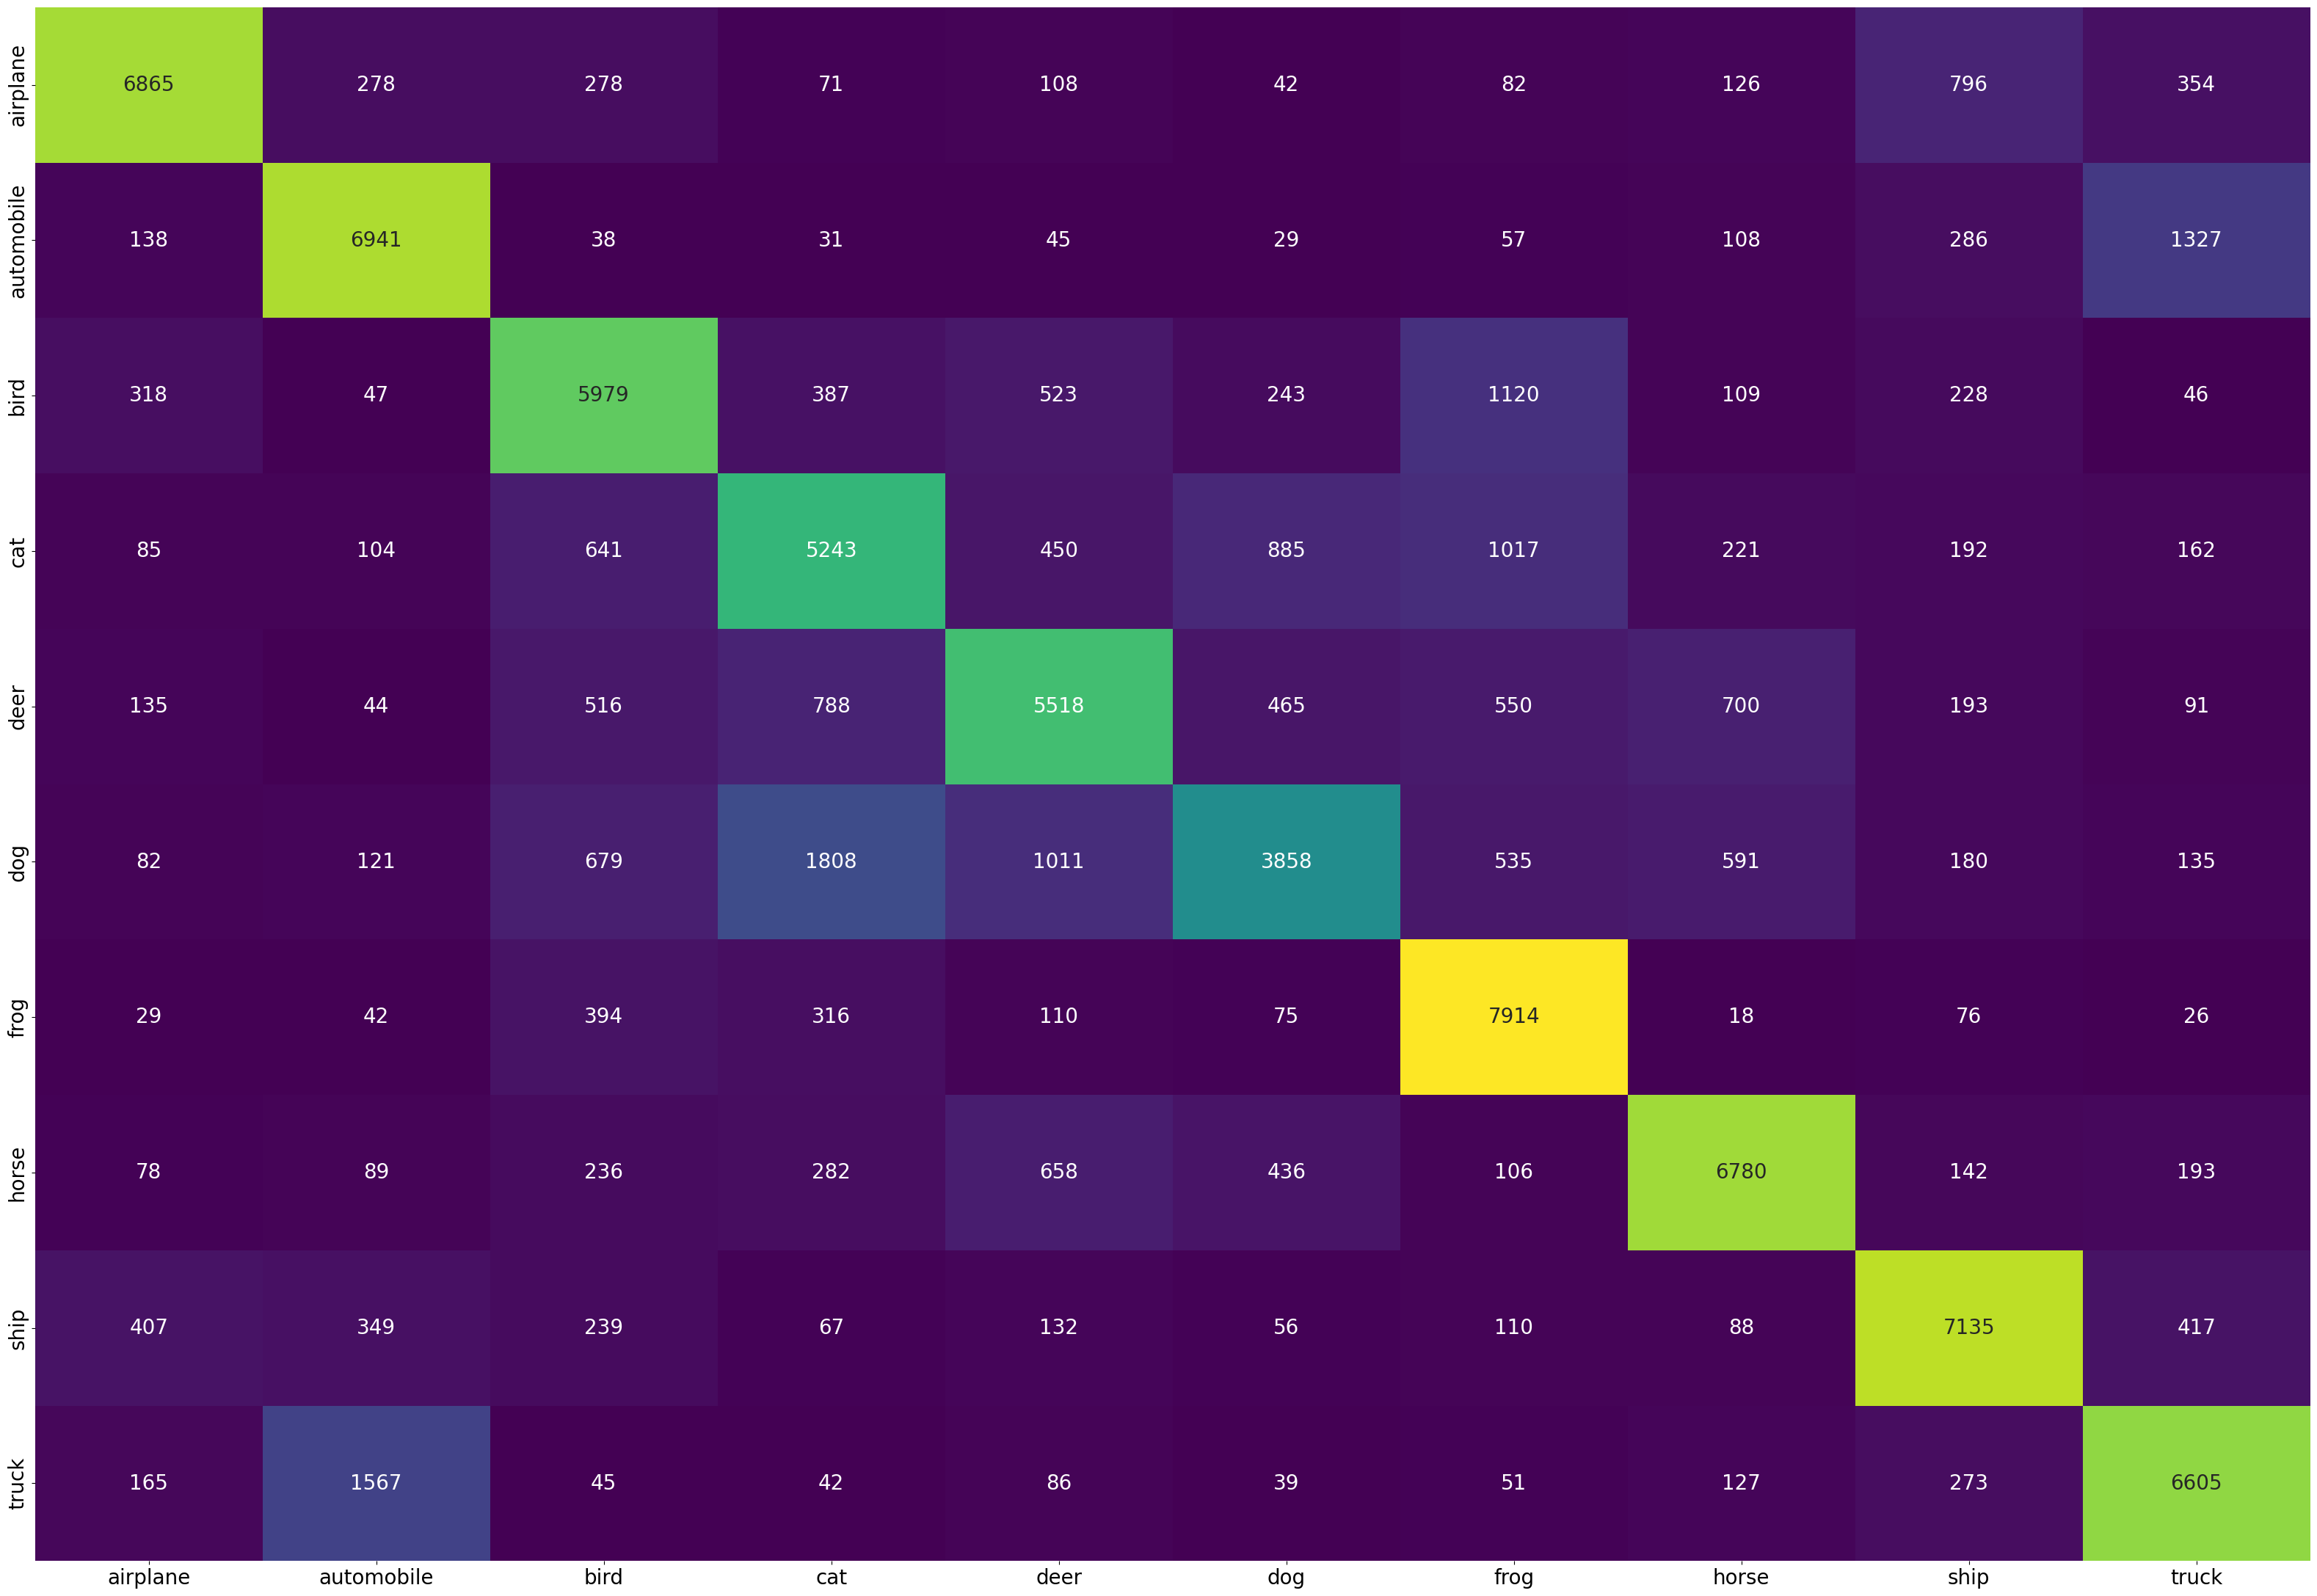

Most common mistakes:
[('dog -> cat: 1808', np.int64(1808)), ('truck -> automobile: 1567', np.int64(1567)), ('automobile -> truck: 1327', np.int64(1327)), ('bird -> frog: 1120', np.int64(1120)), ('cat -> frog: 1017', np.int64(1017))]
Macro Average Precision: 0.74153071641922
Macro Average Recall: 0.7365000247955322
Macro Average F1: 0.7361528873443604
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


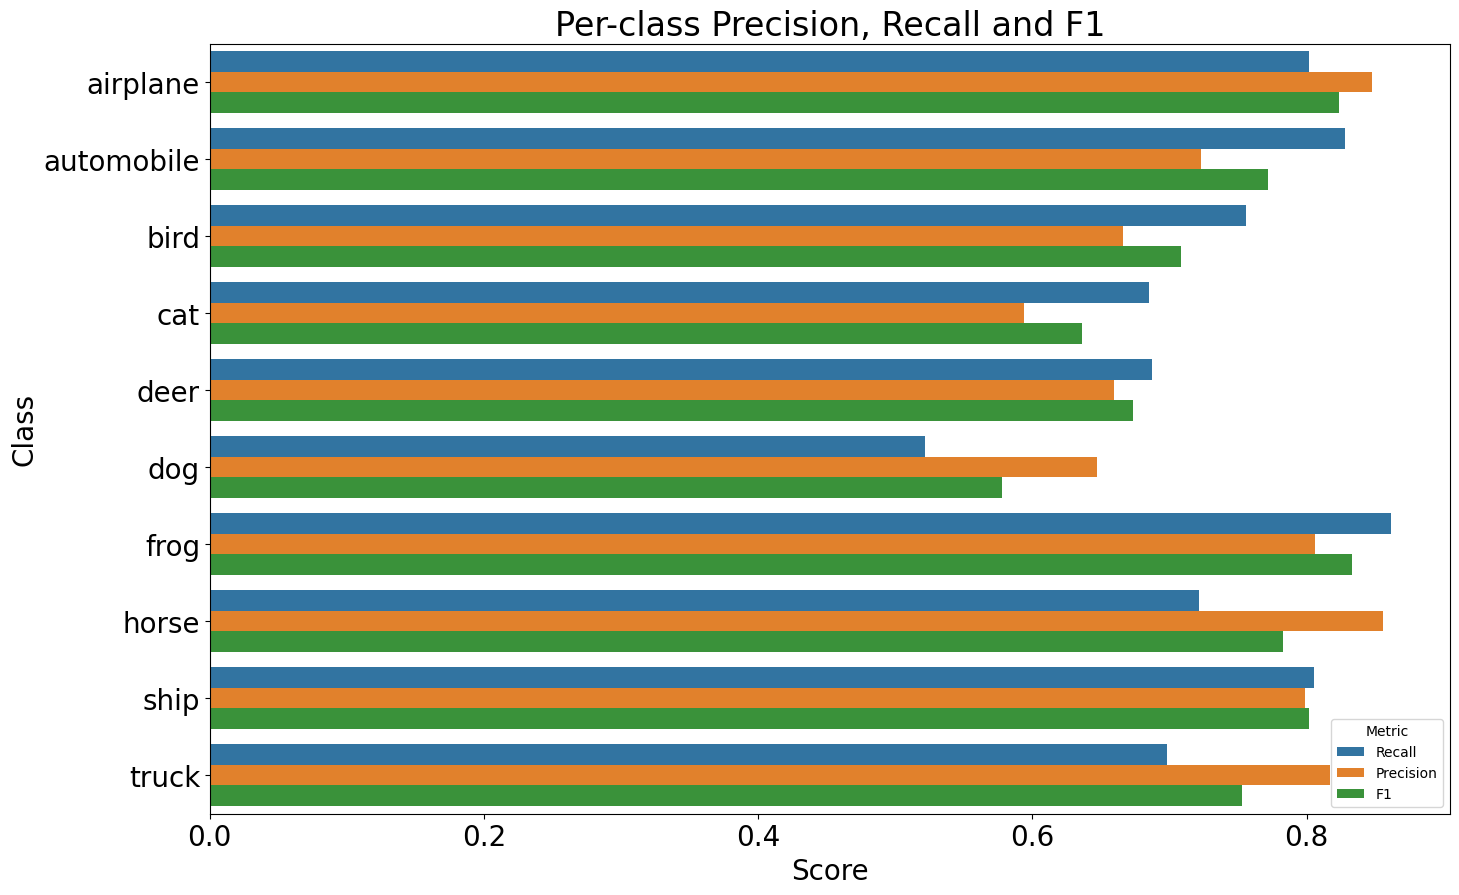

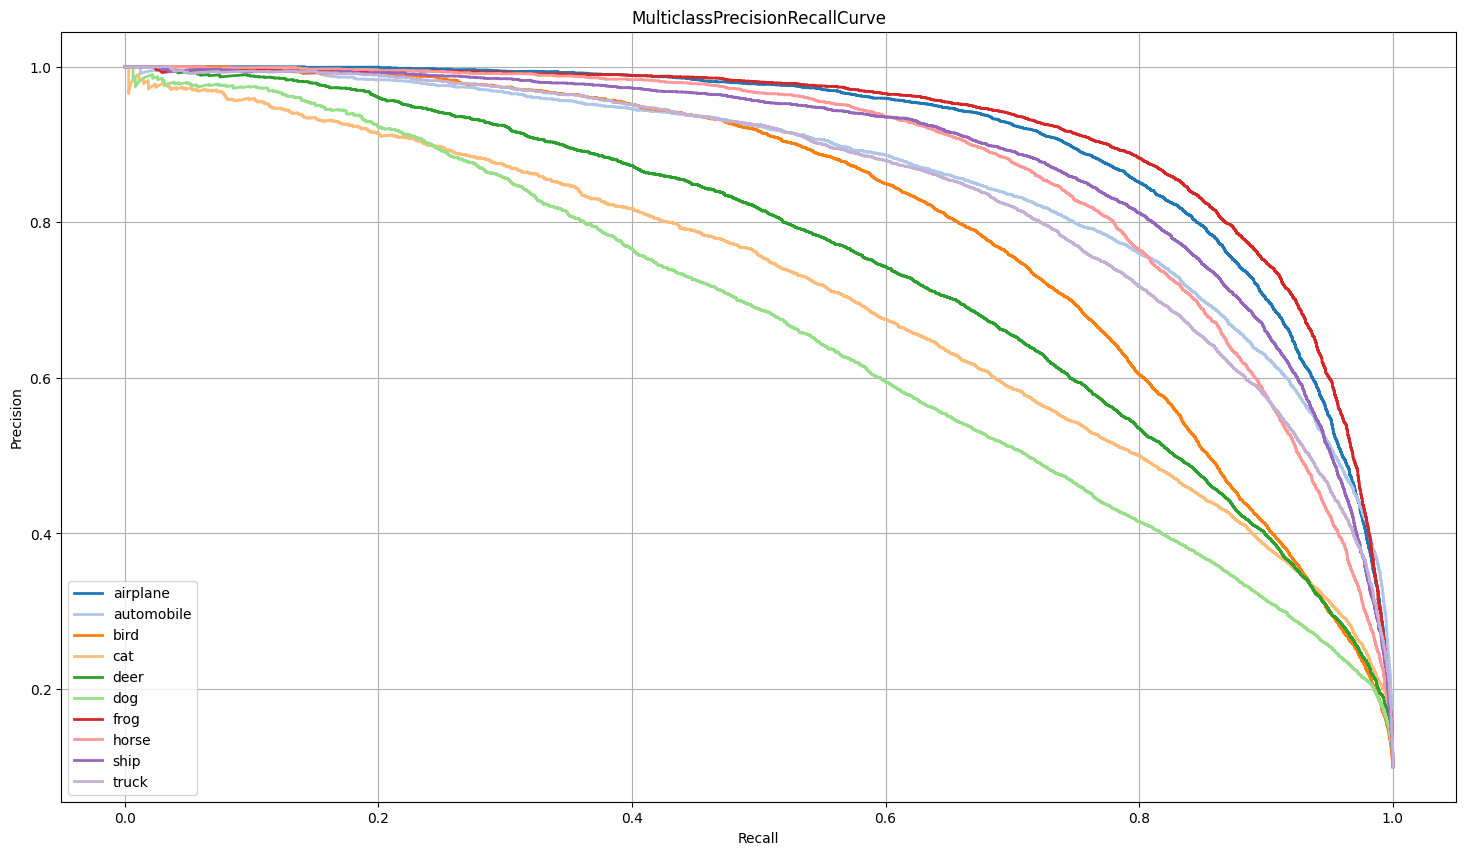

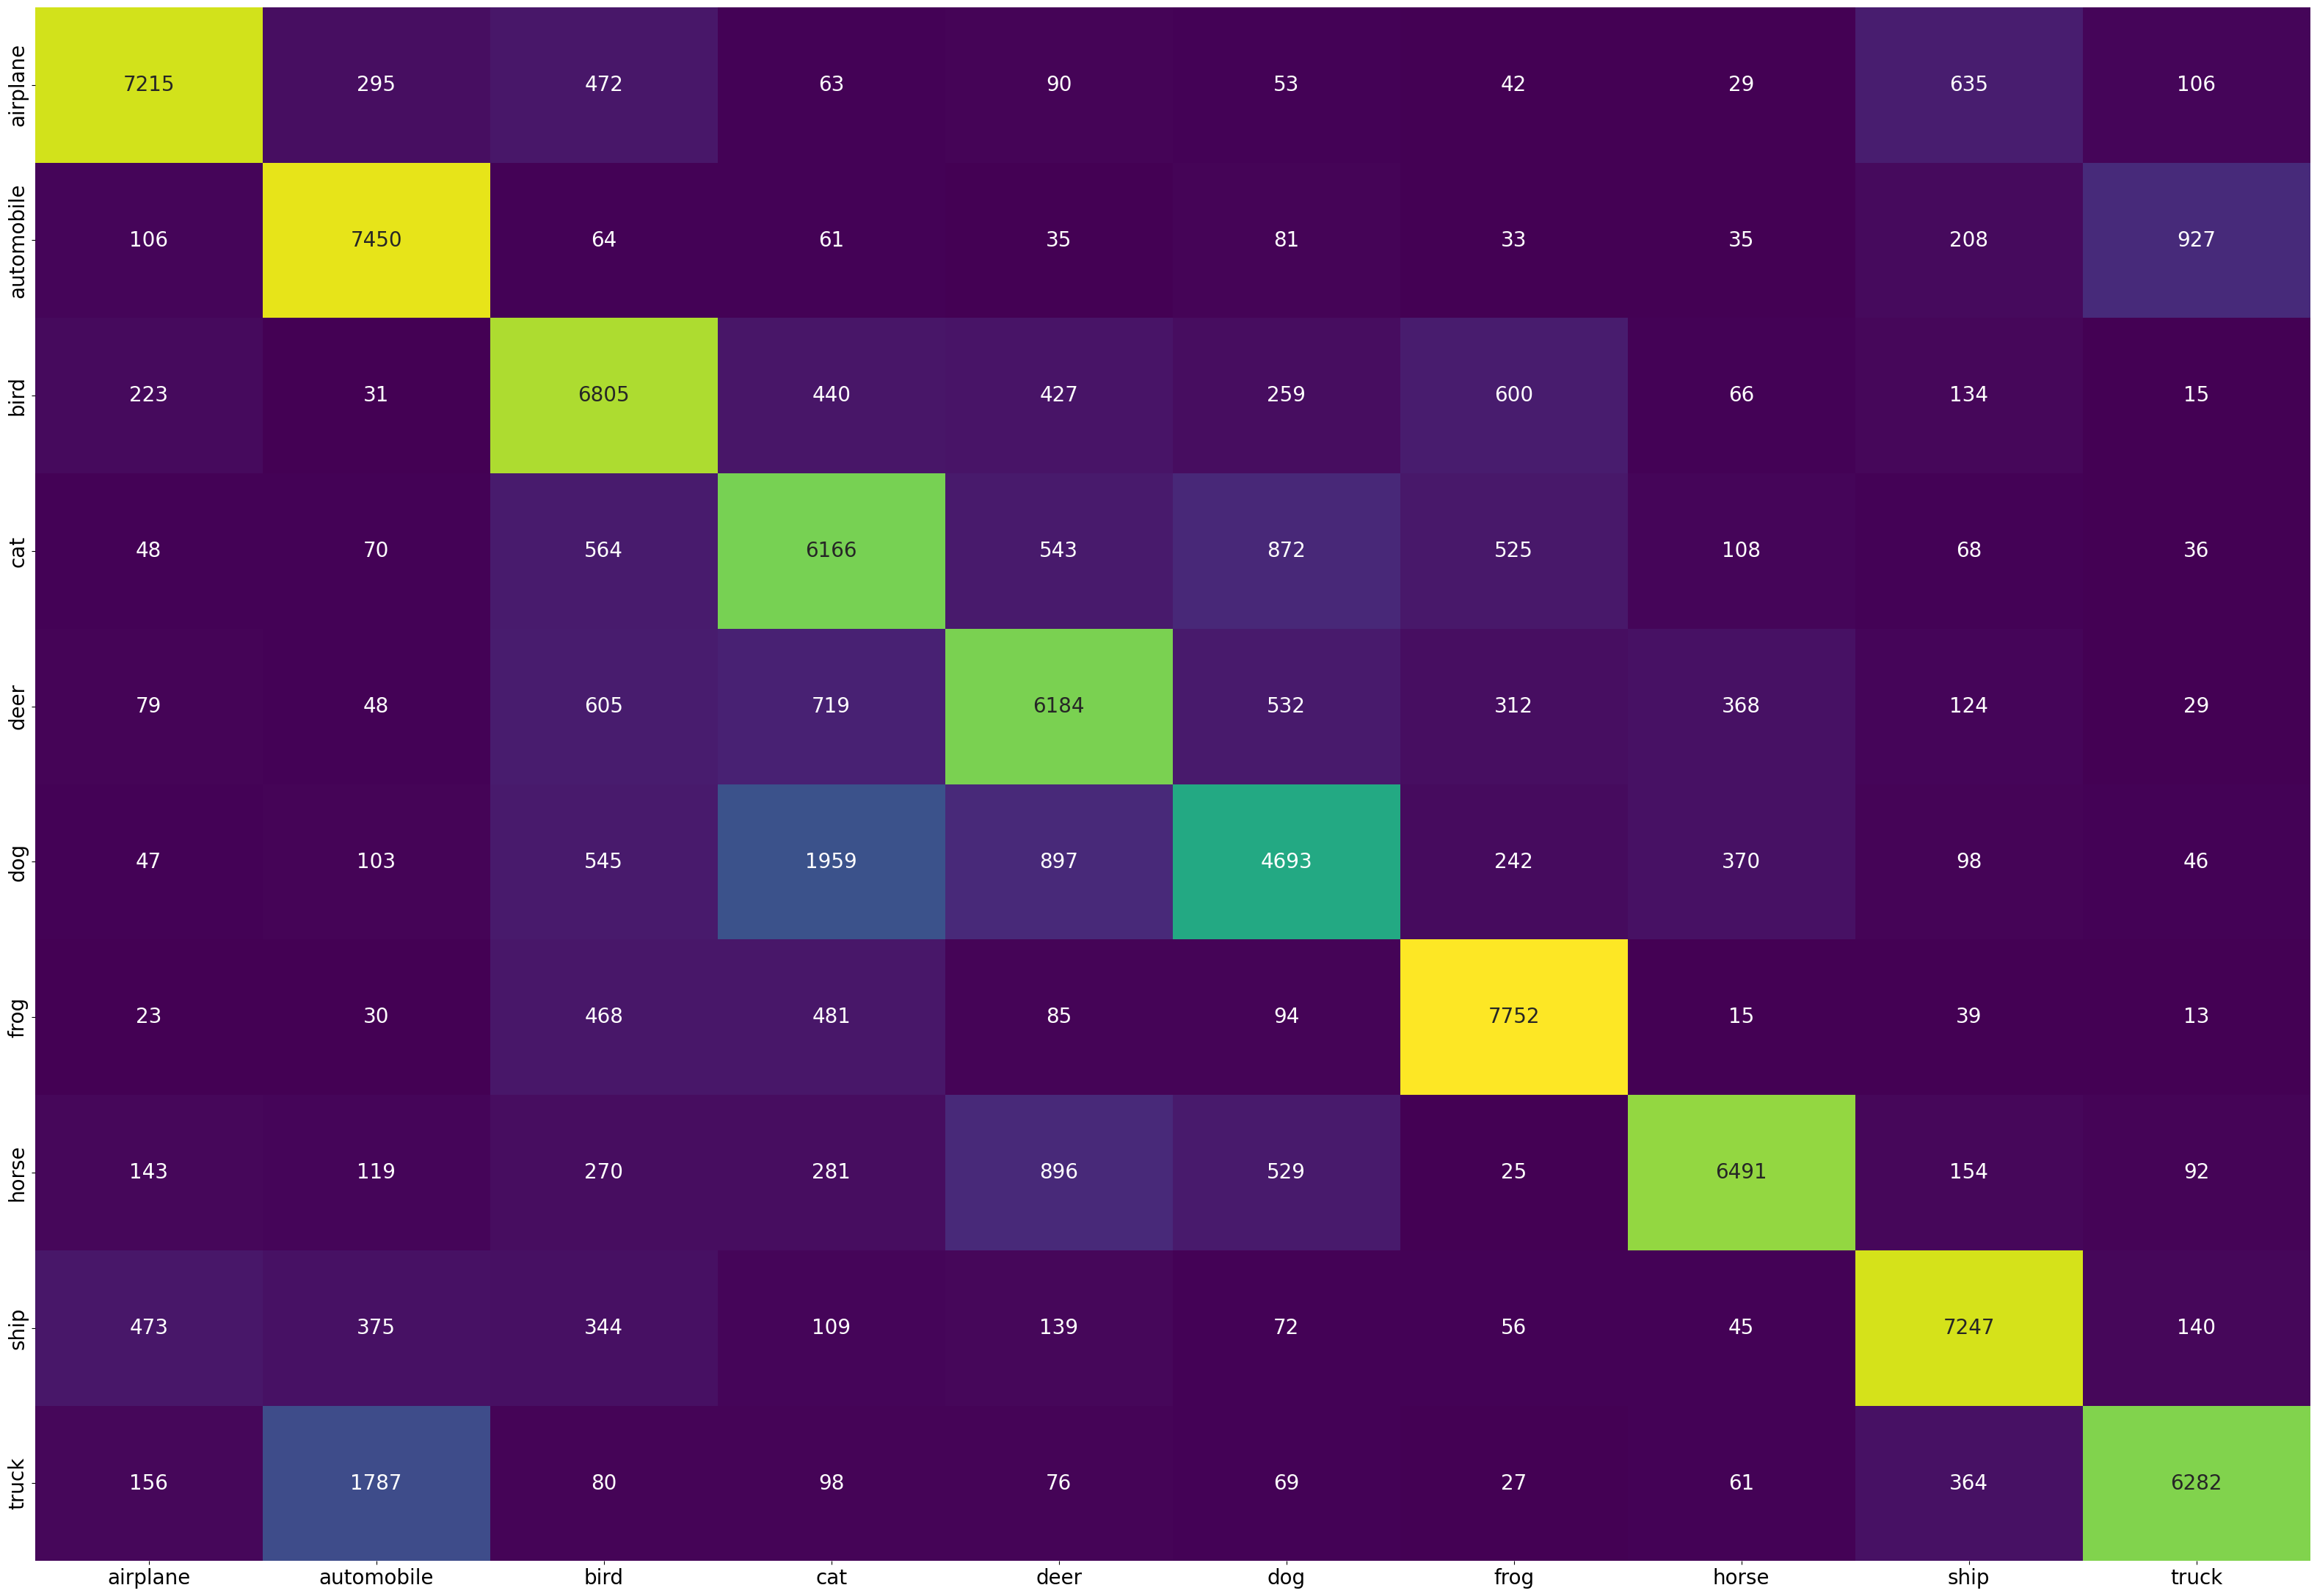

Most common mistakes:
[('dog -> cat: 1959', np.int64(1959)), ('truck -> automobile: 1787', np.int64(1787)), ('automobile -> truck: 927', np.int64(927)), ('dog -> deer: 897', np.int64(897)), ('horse -> deer: 896', np.int64(896))]
Macro Average Precision: 0.8409402370452881
Macro Average Recall: 0.8388556241989136
Macro Average F1: 0.8395659923553467
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


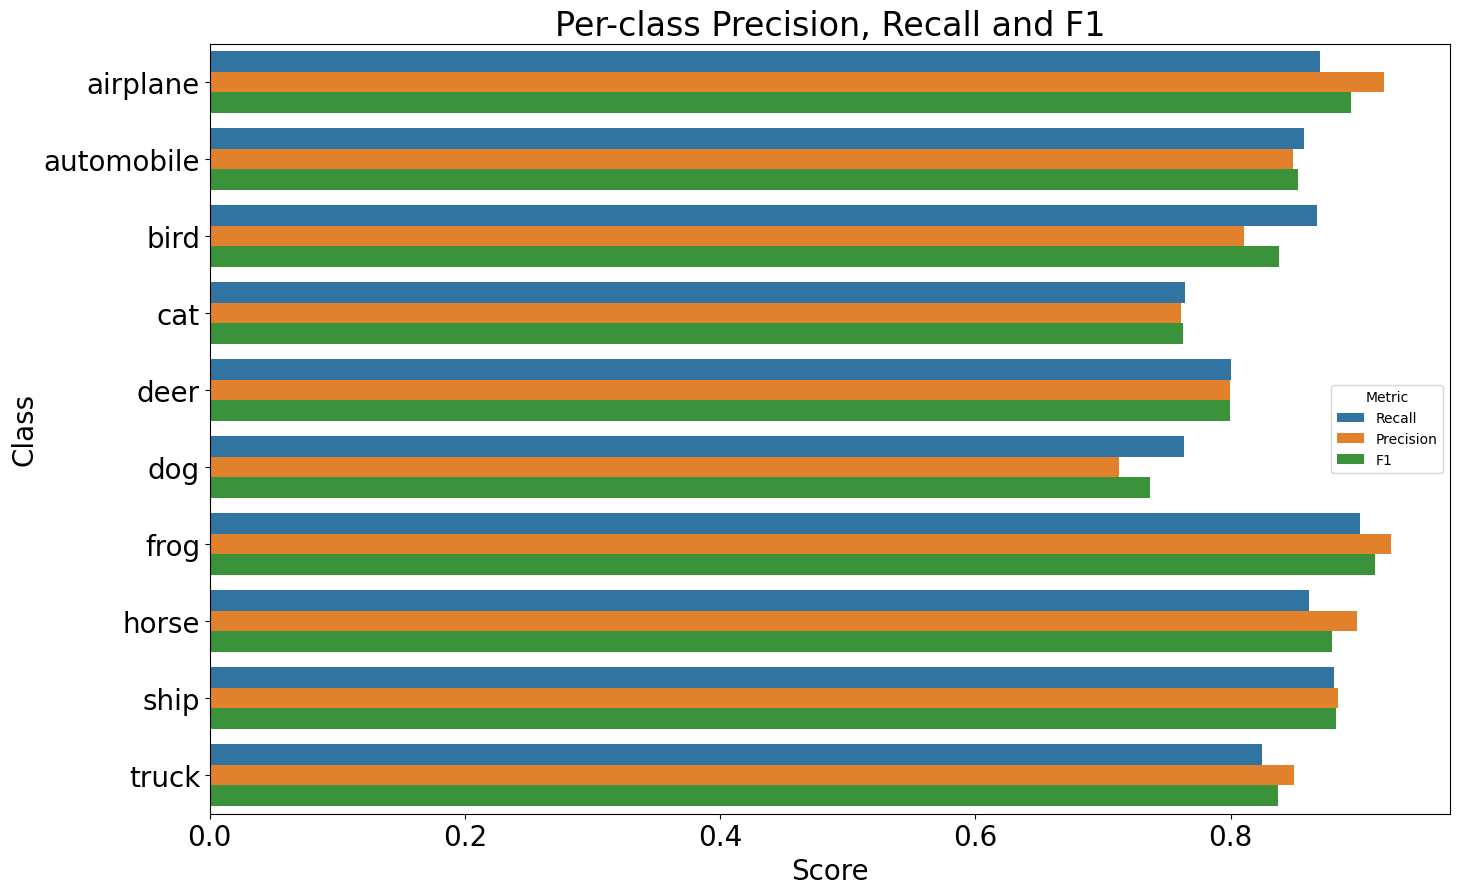

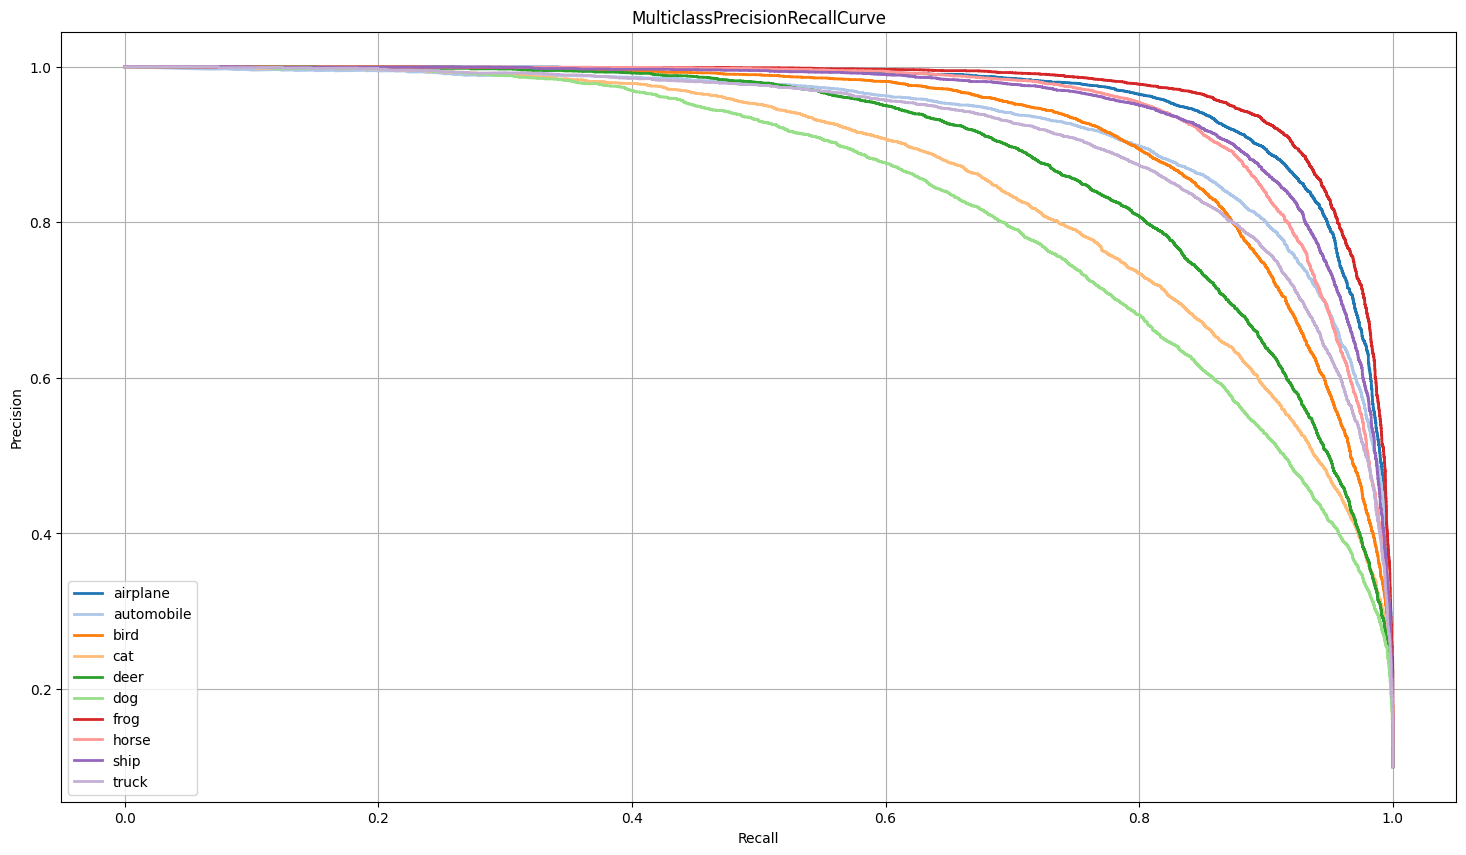

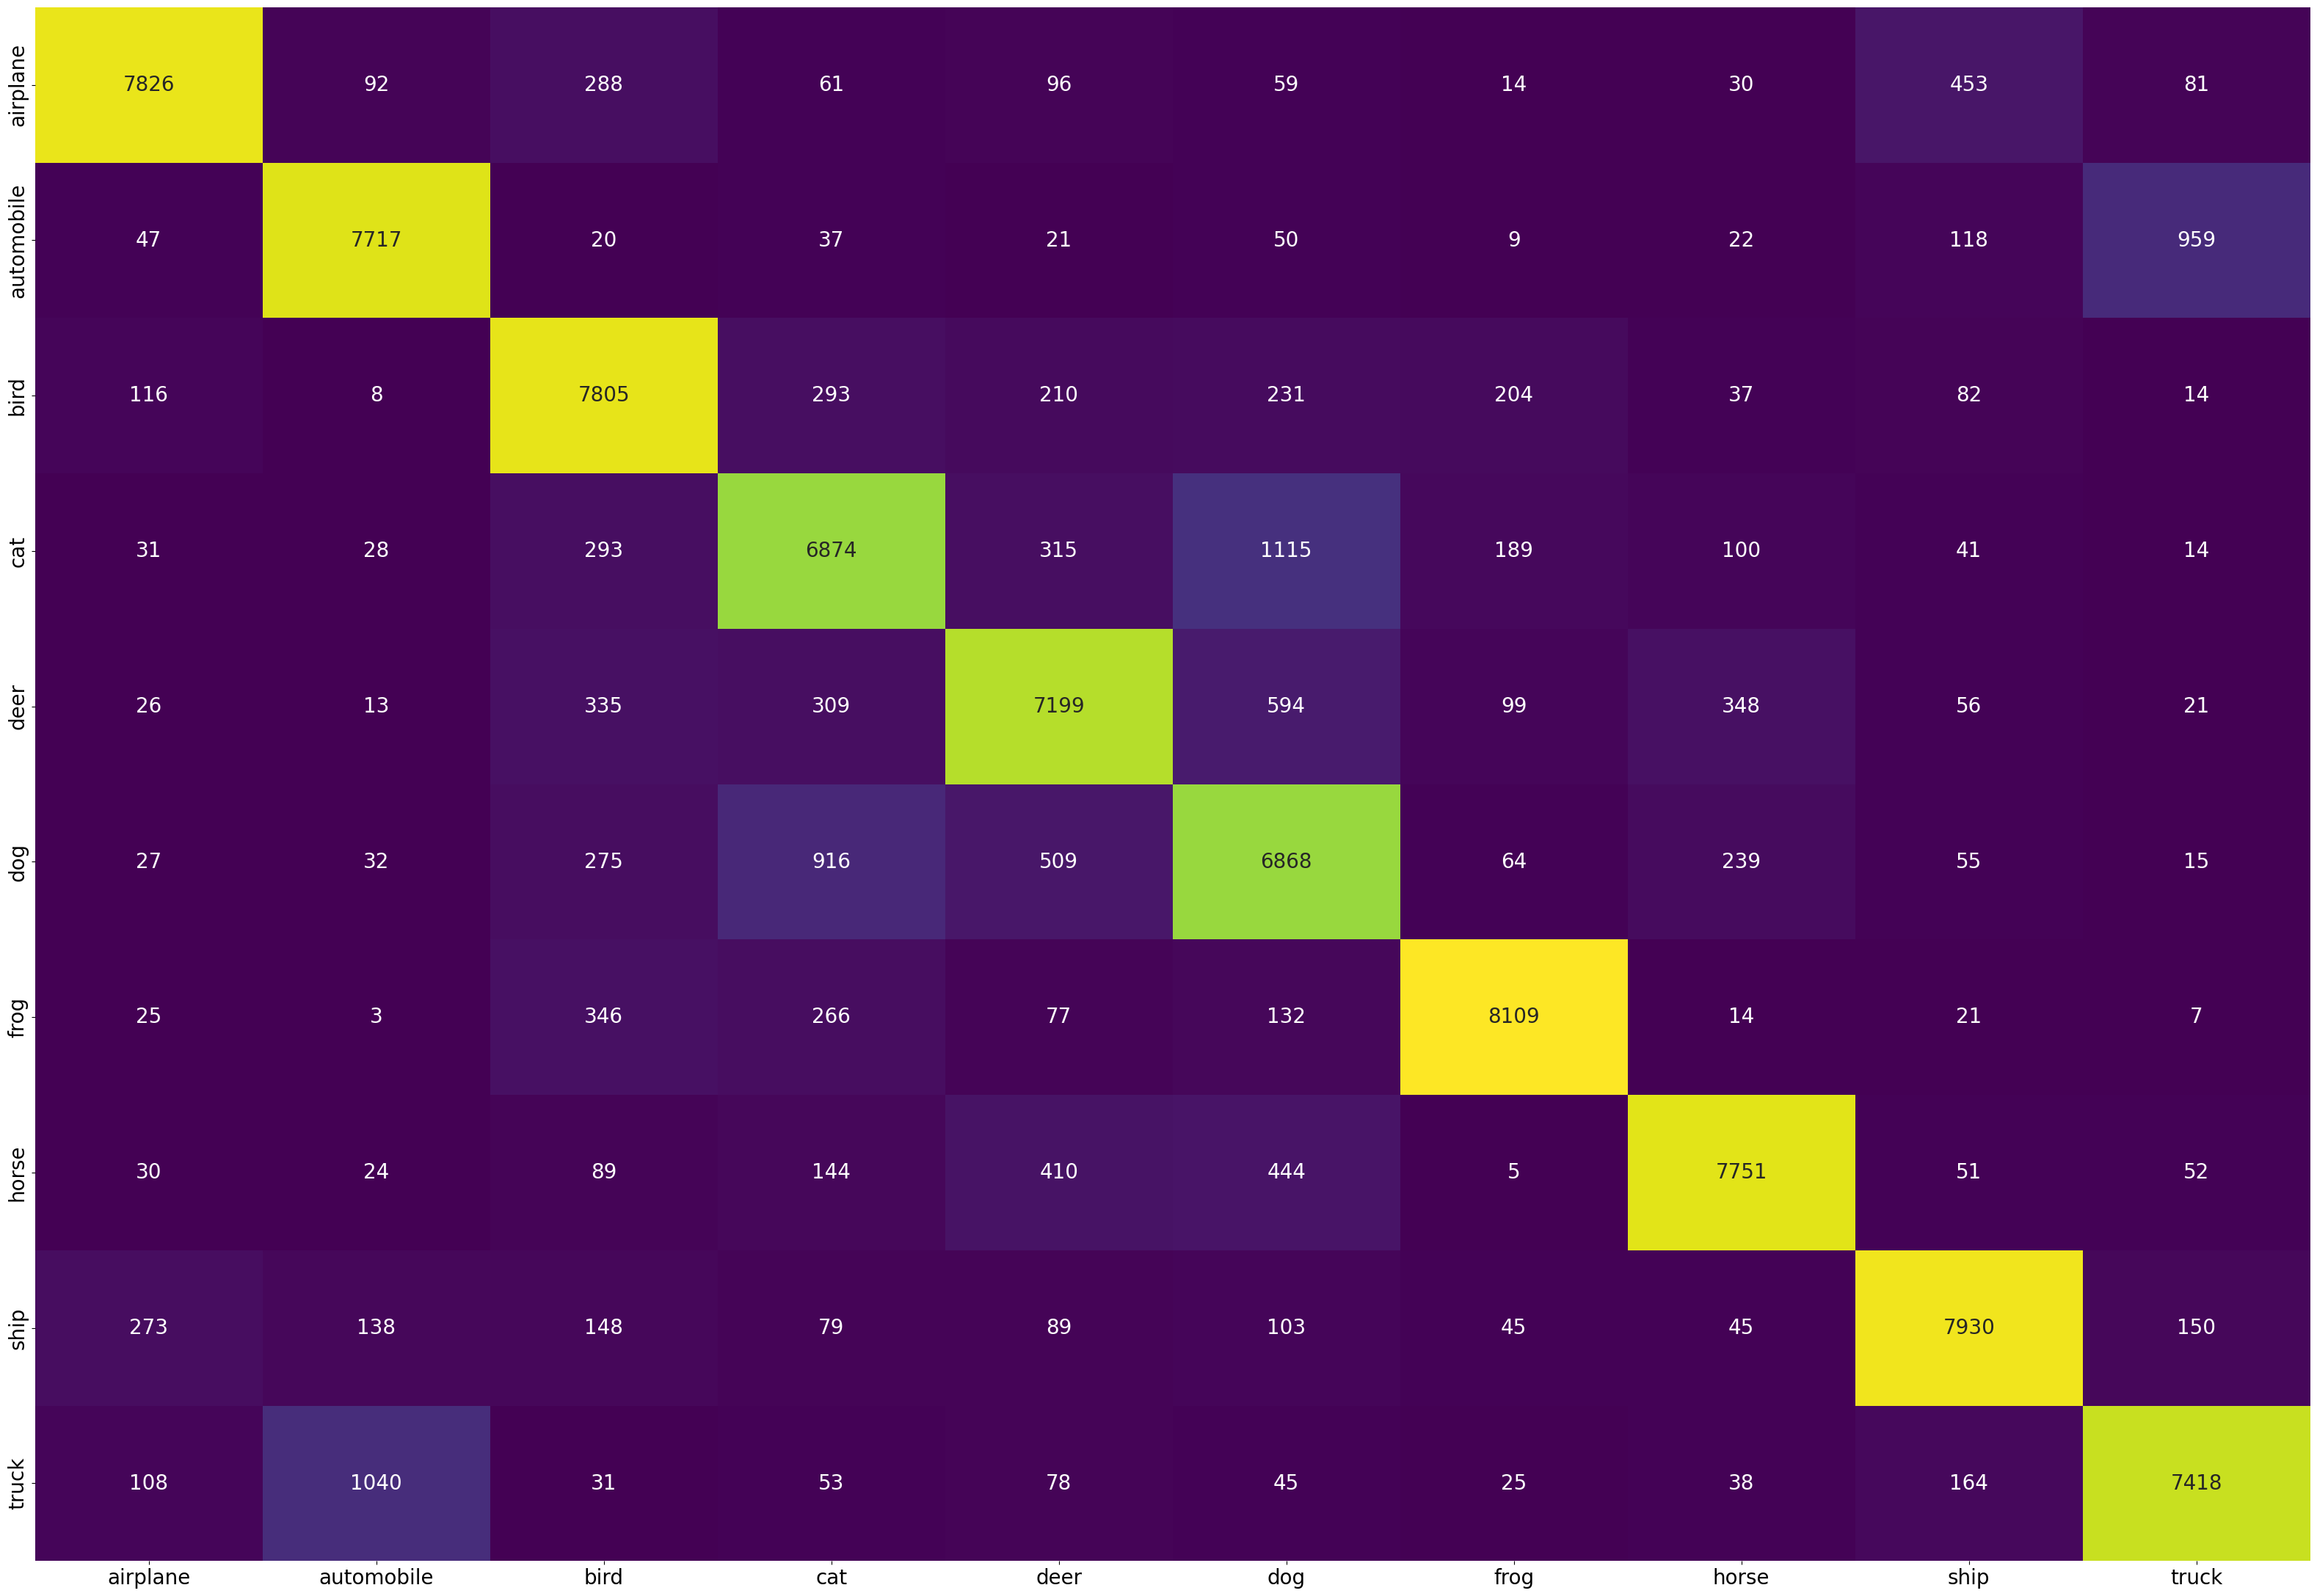

Most common mistakes:
[('cat -> dog: 1115', np.int64(1115)), ('truck -> automobile: 1040', np.int64(1040)), ('automobile -> truck: 959', np.int64(959)), ('dog -> cat: 916', np.int64(916)), ('deer -> dog: 594', np.int64(594))]
Macro Average Precision: 0.6025811433792114
Macro Average Recall: 0.6012444496154785
Macro Average F1: 0.5975288152694702
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


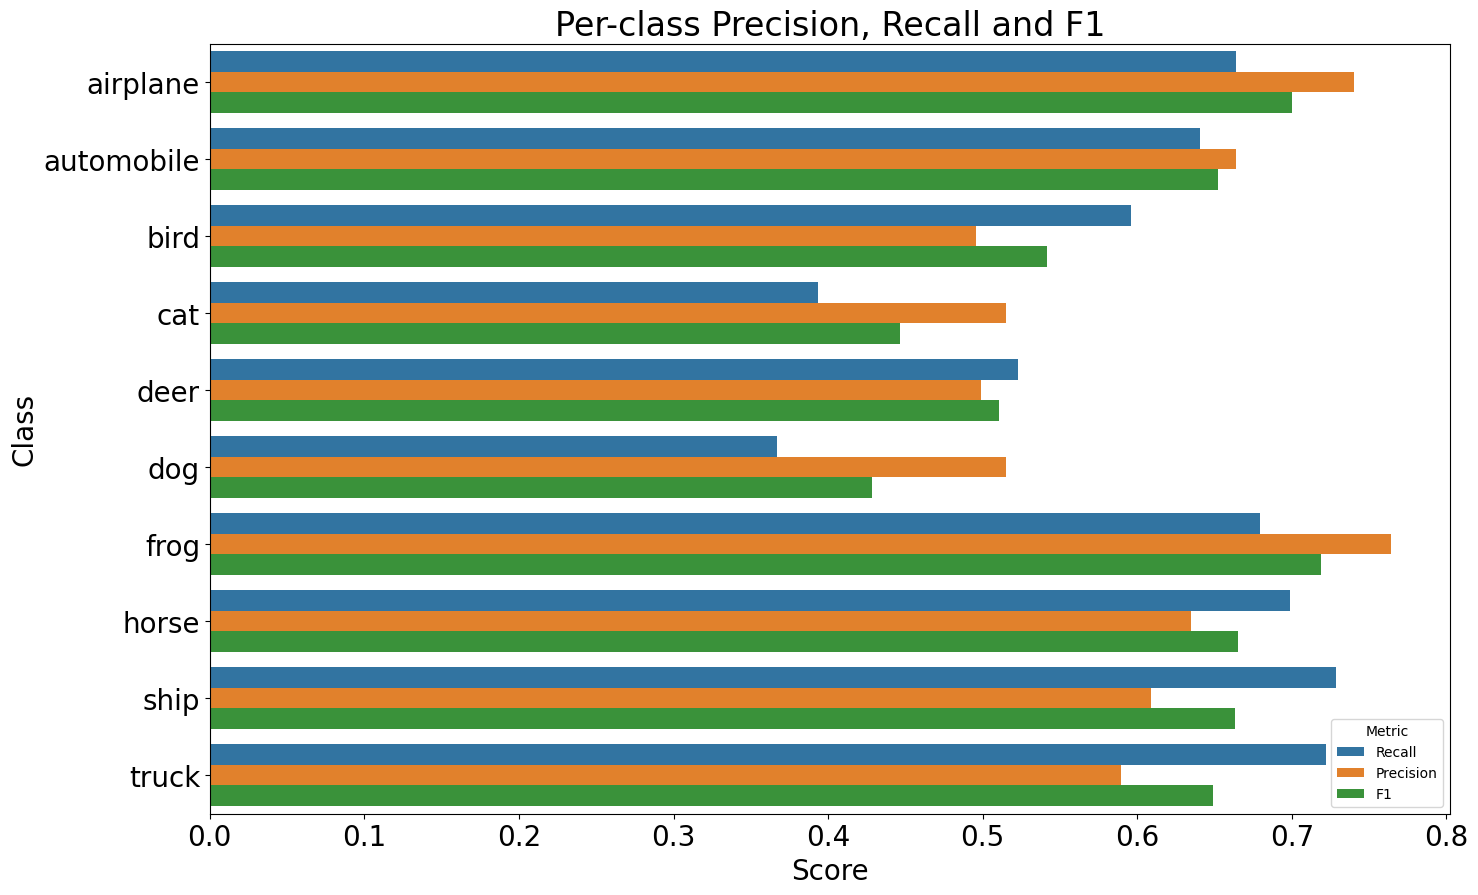

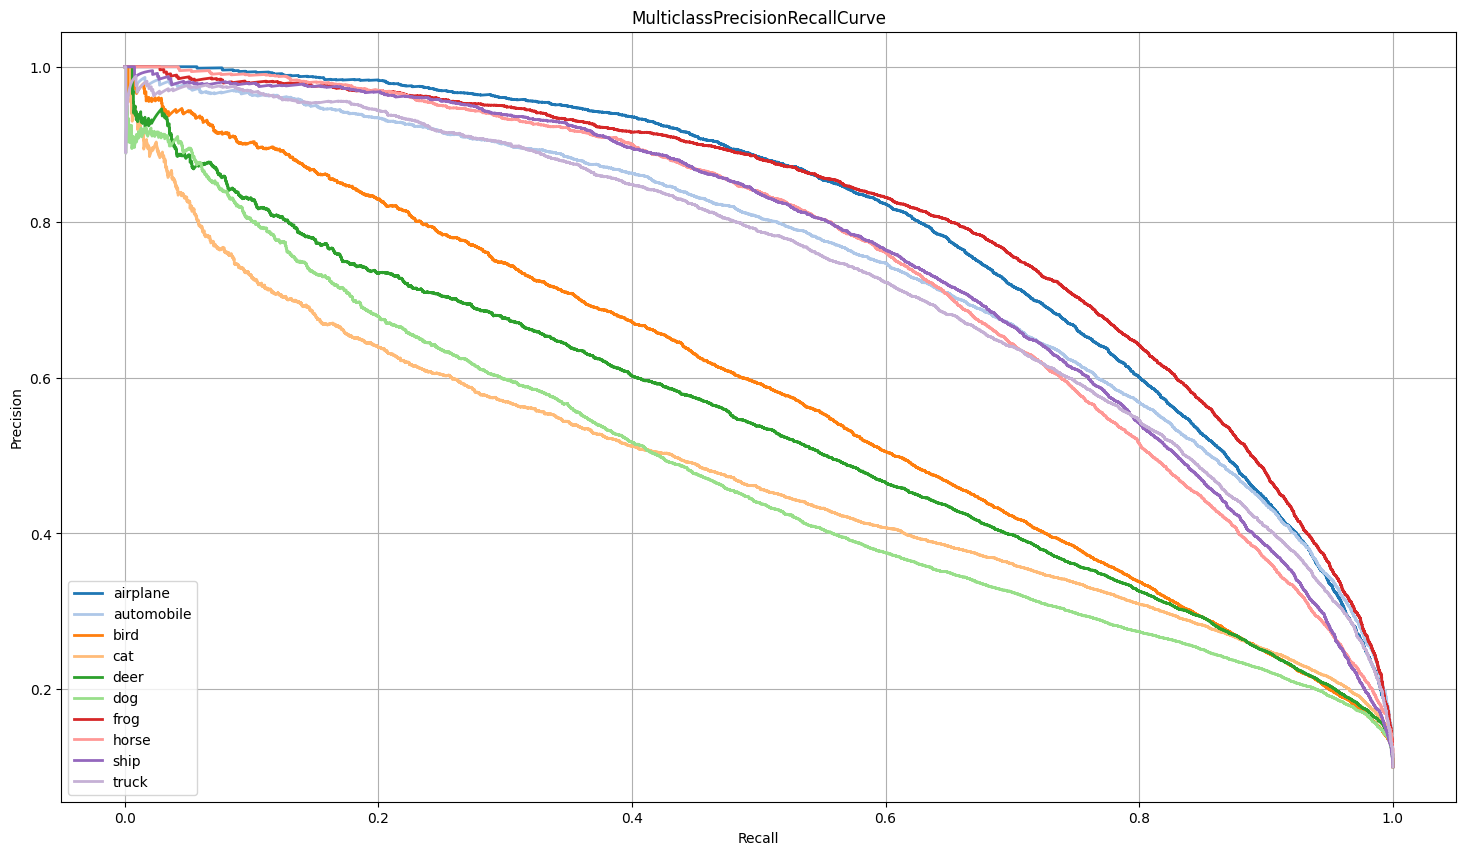

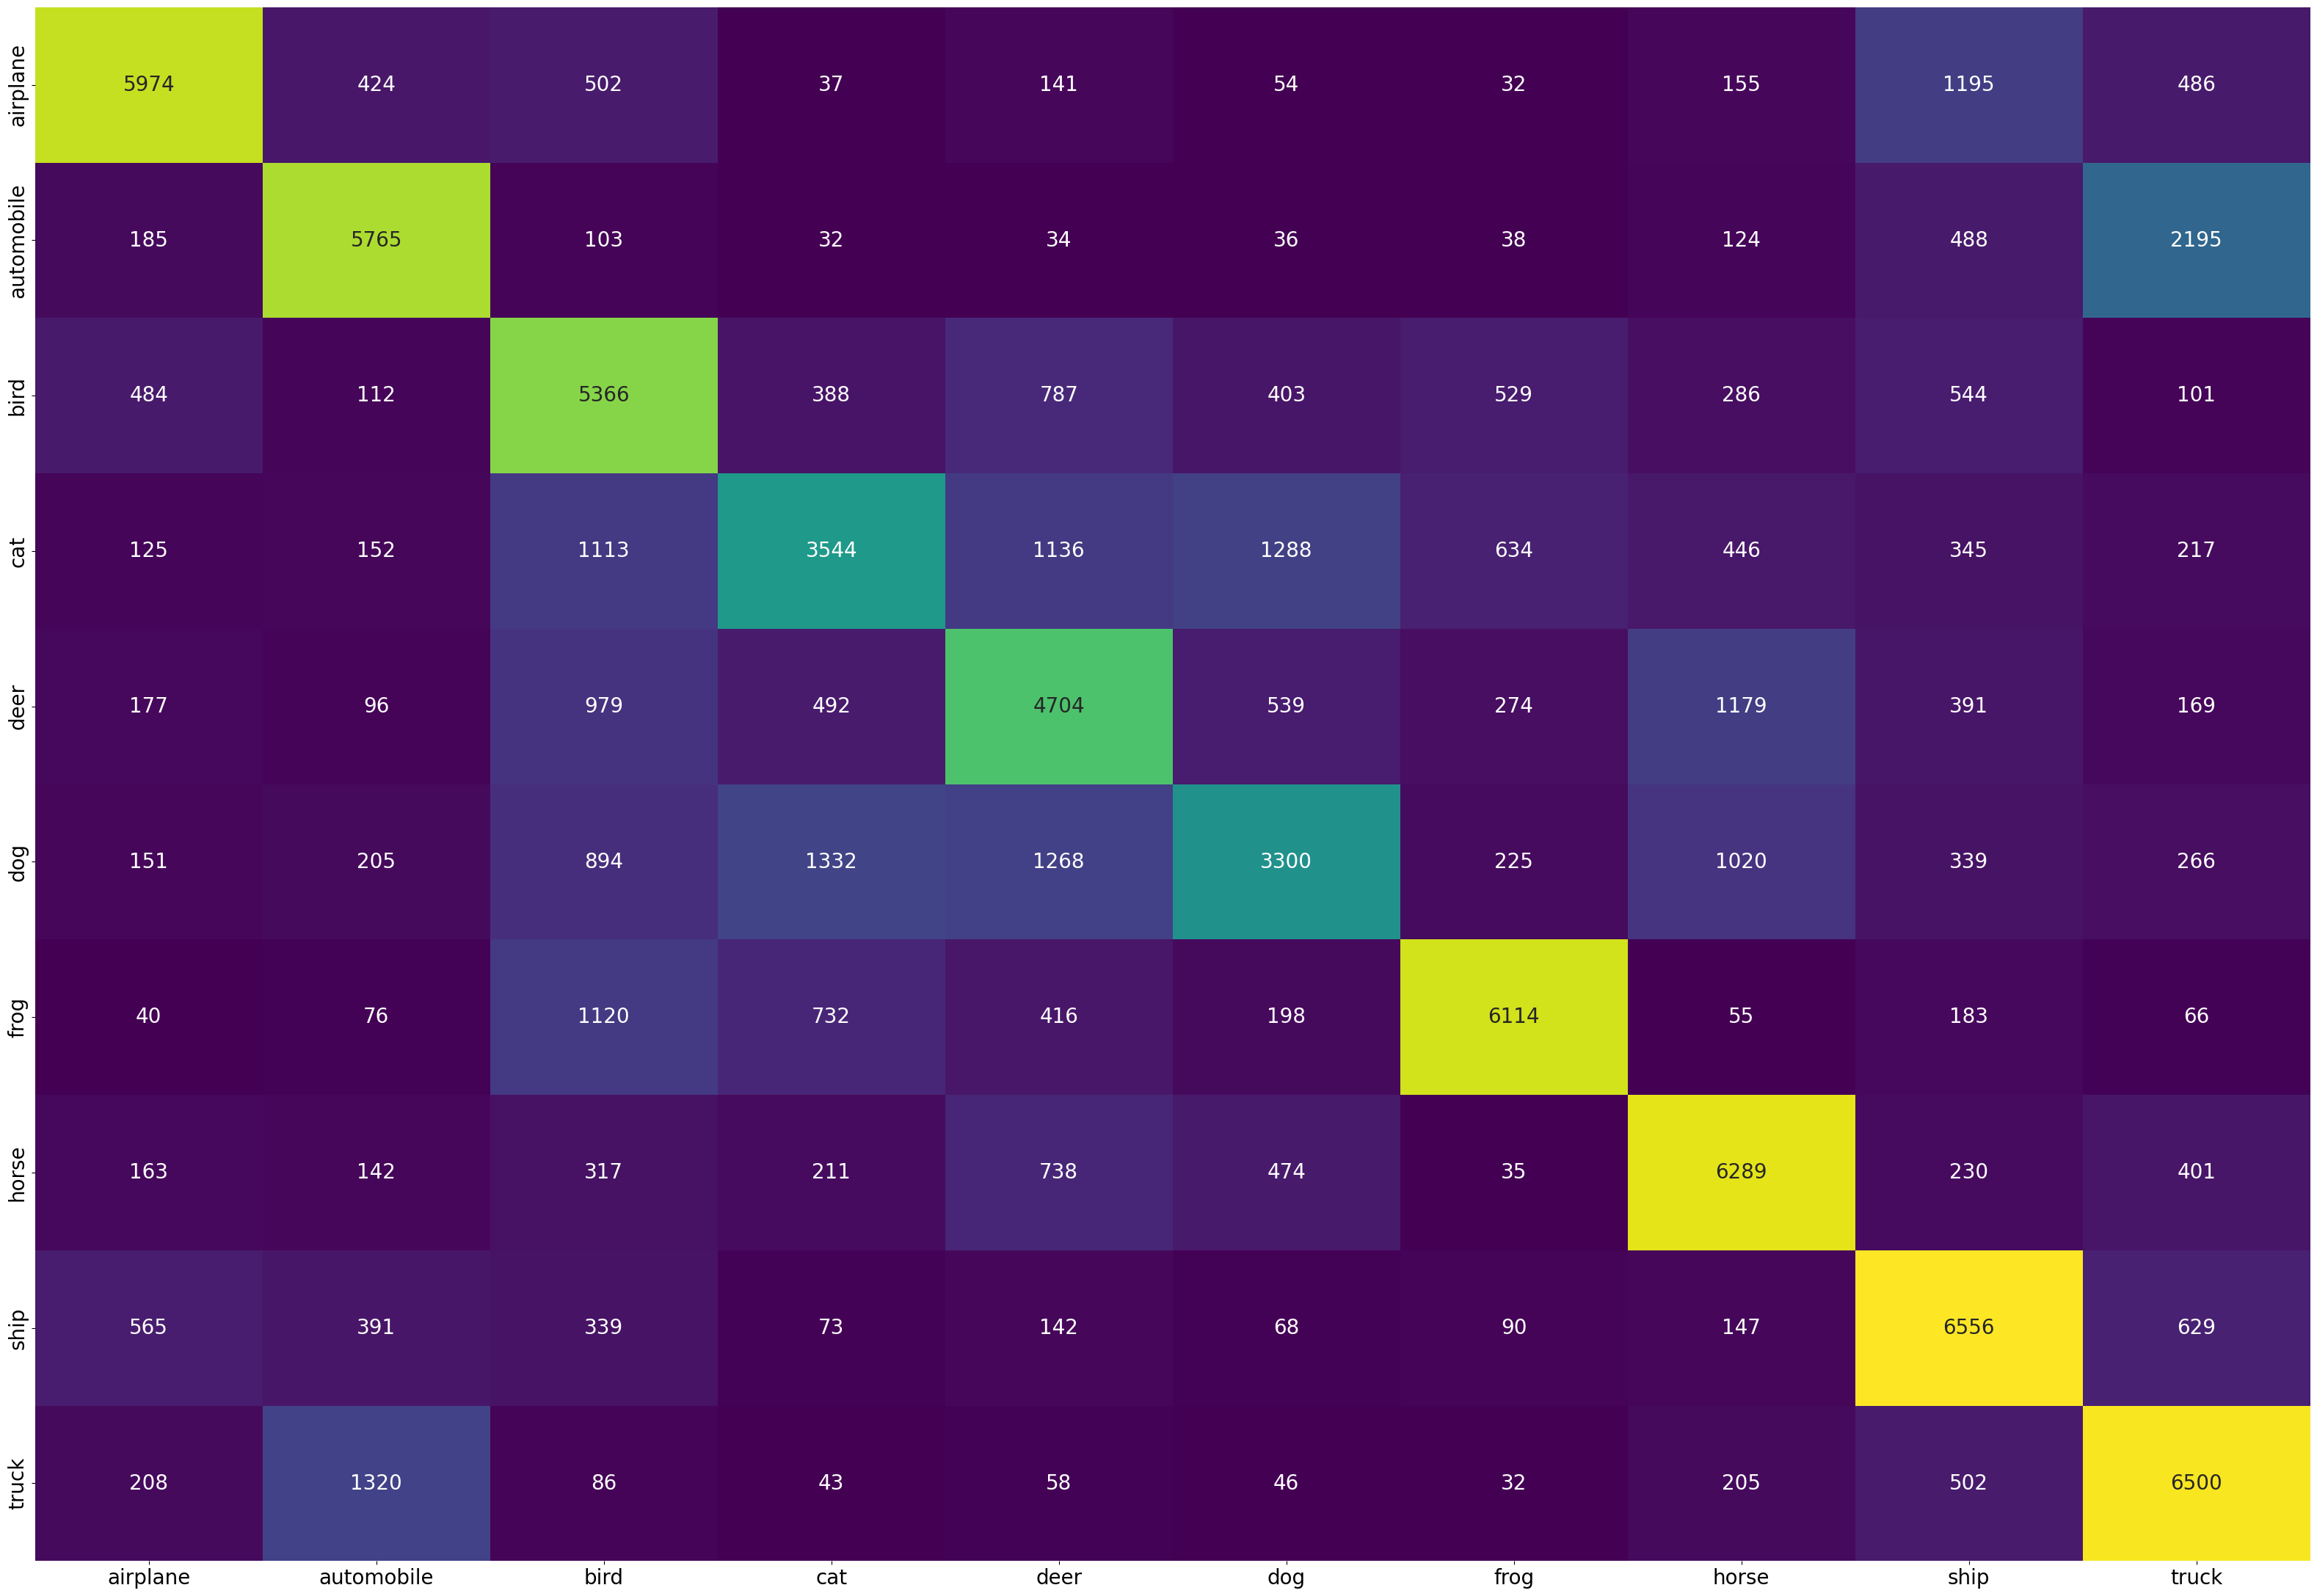

Most common mistakes:
[('automobile -> truck: 2195', np.int64(2195)), ('dog -> cat: 1332', np.int64(1332)), ('truck -> automobile: 1320', np.int64(1320)), ('cat -> dog: 1288', np.int64(1288)), ('dog -> deer: 1268', np.int64(1268))]
Macro Average Precision: 0.6024105548858643
Macro Average Recall: 0.595466673374176
Macro Average F1: 0.5967885851860046
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


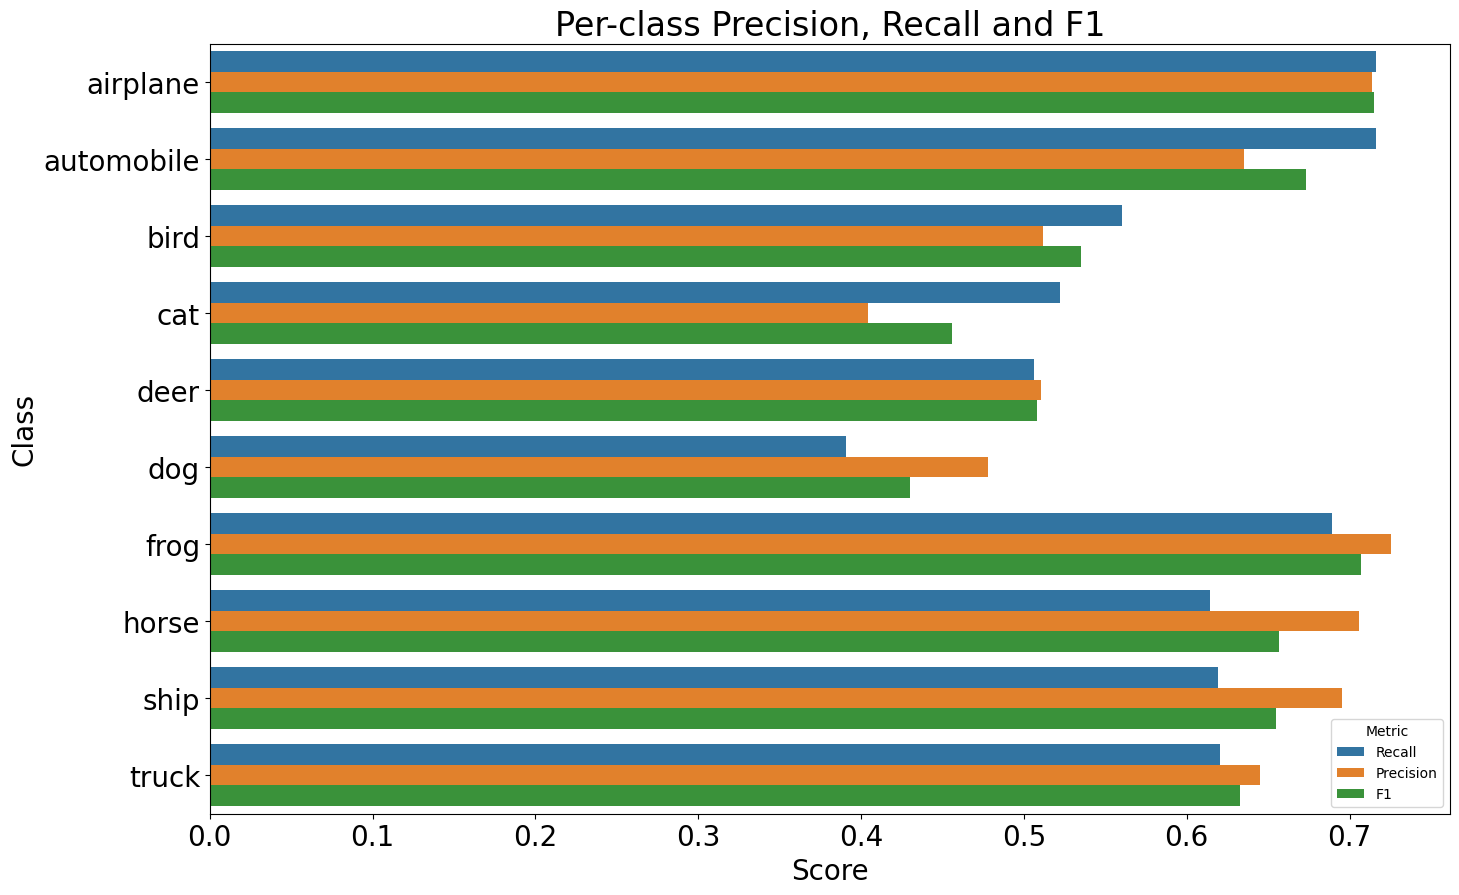

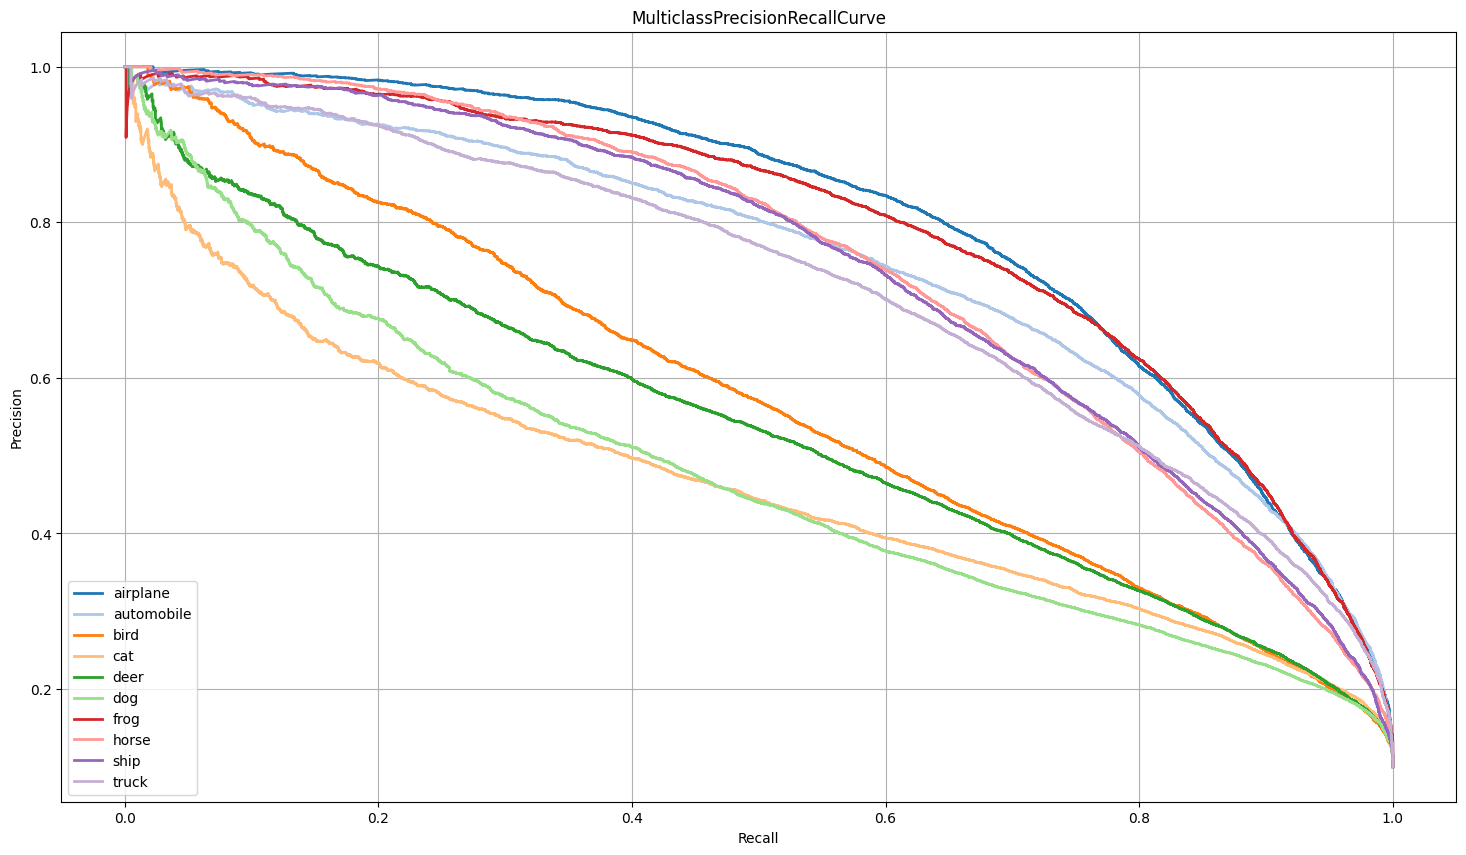

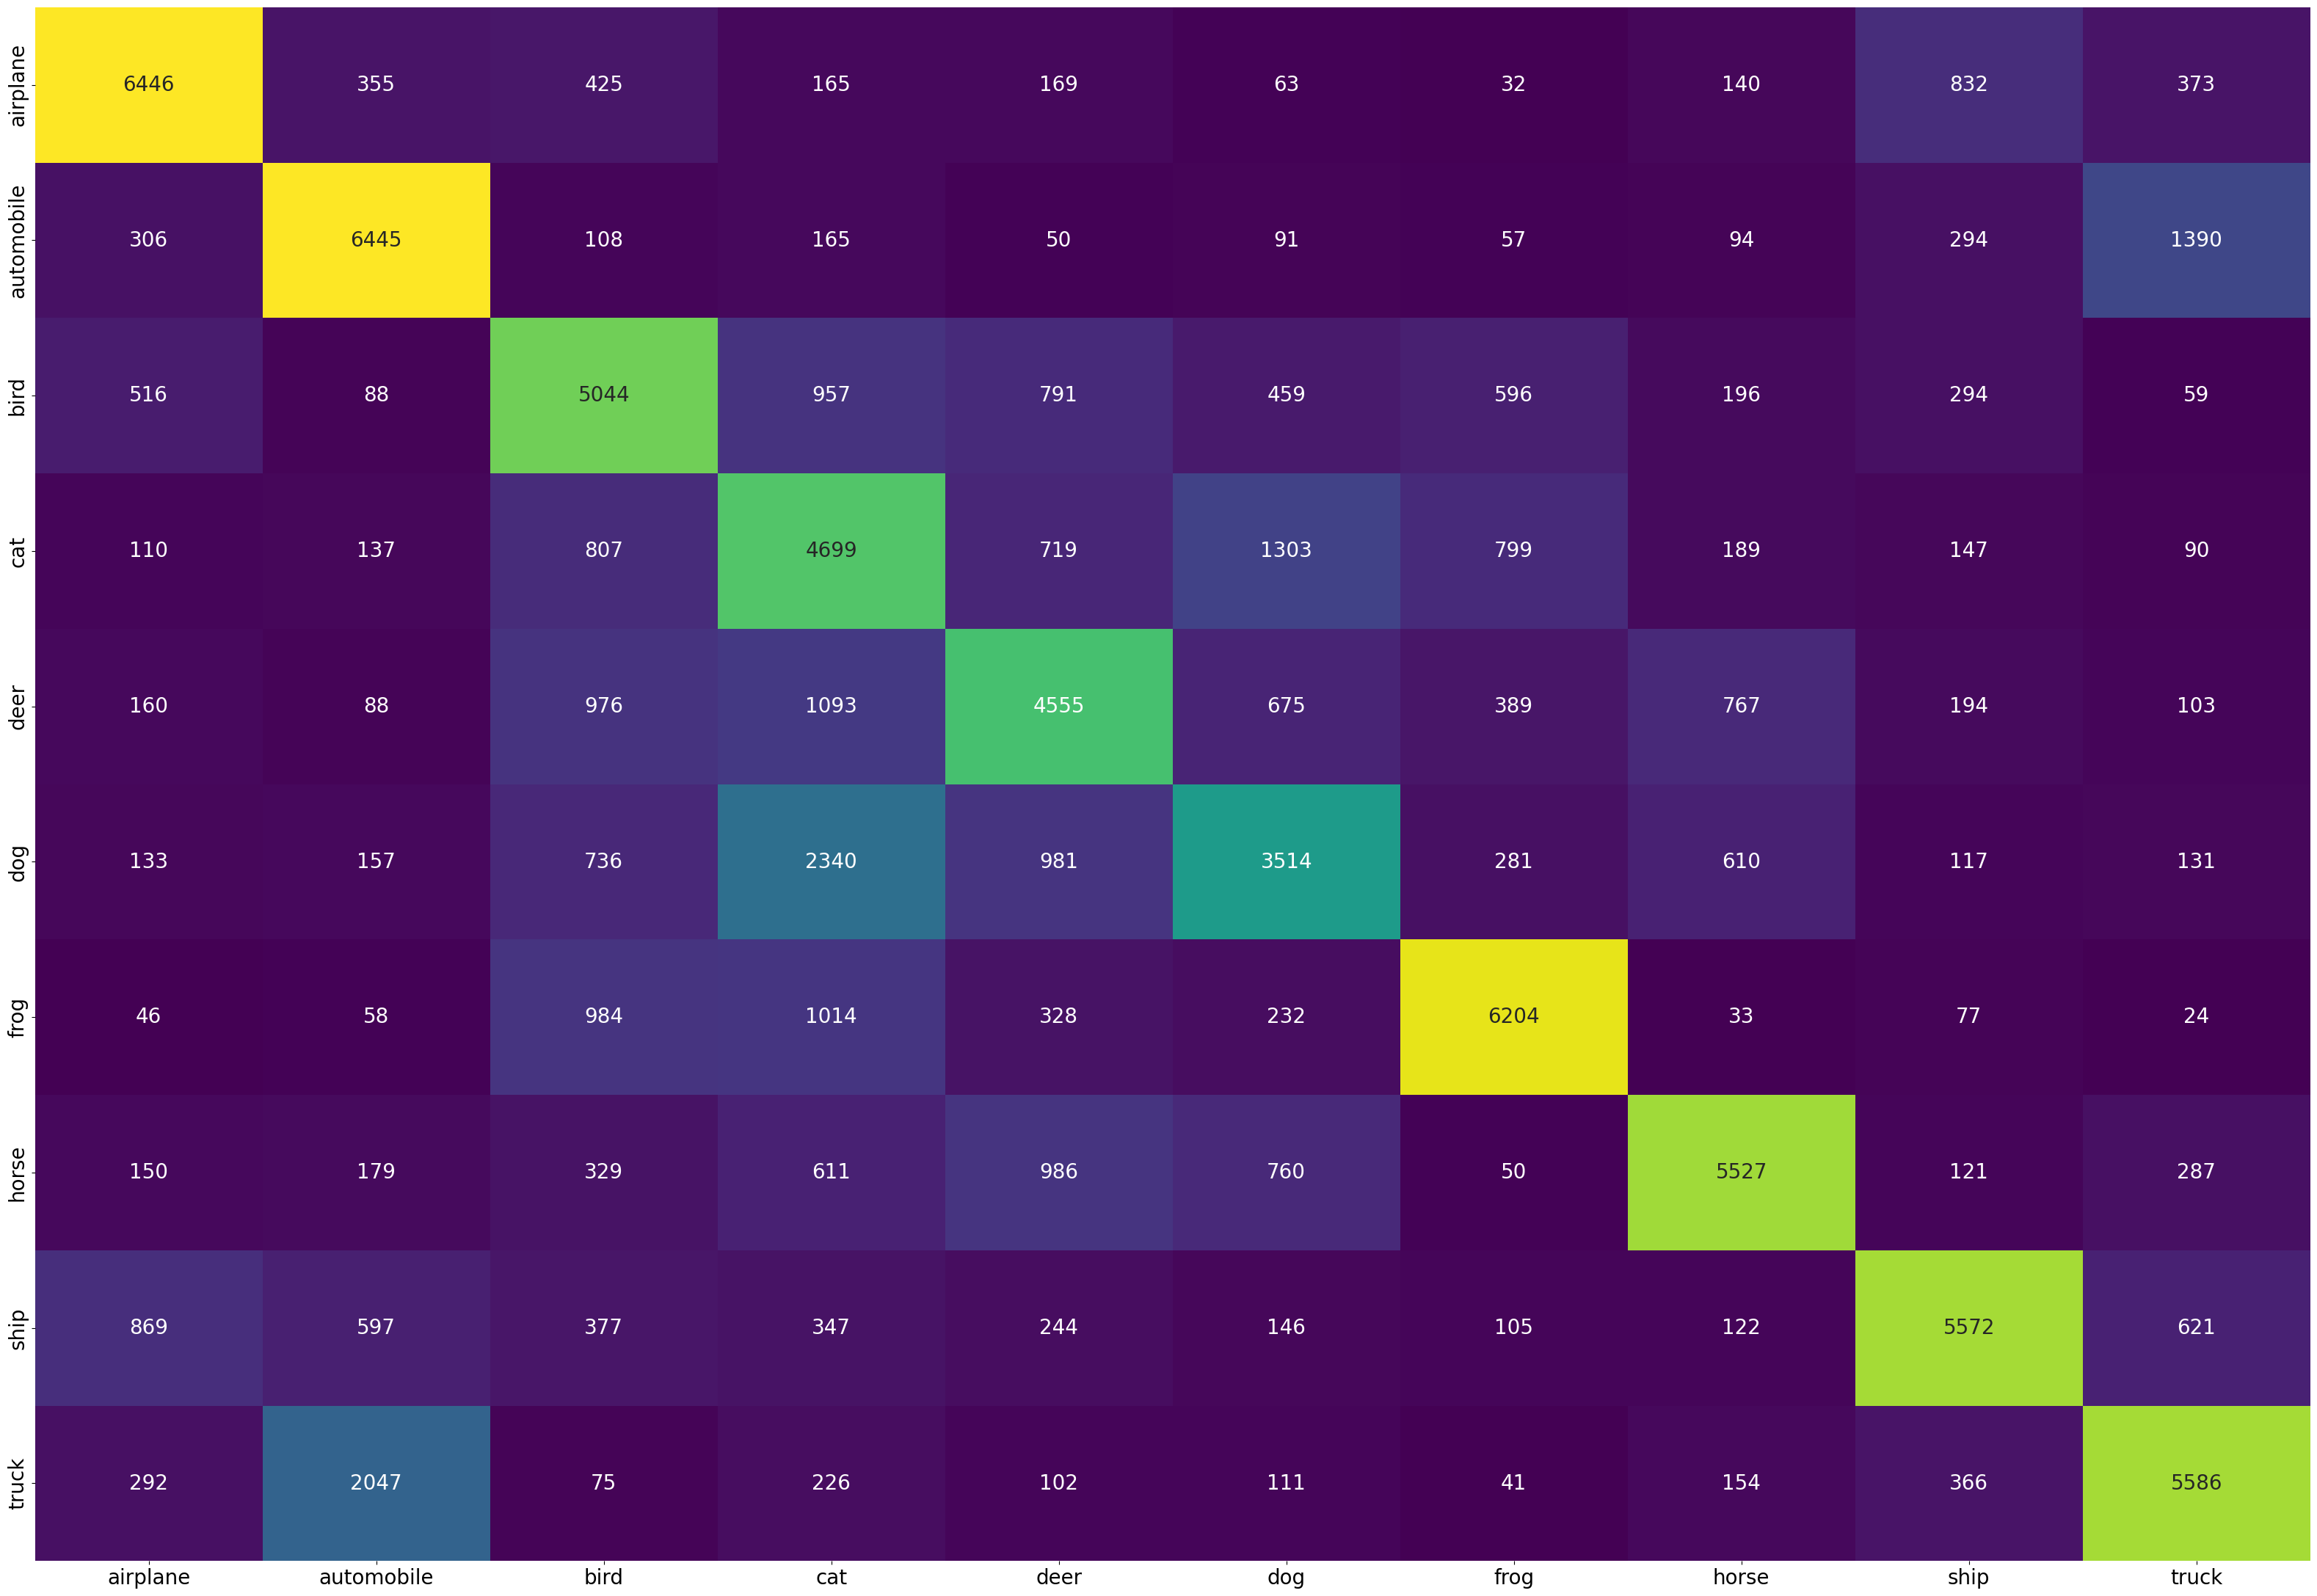

Most common mistakes:
[('dog -> cat: 2340', np.int64(2340)), ('truck -> automobile: 2047', np.int64(2047)), ('automobile -> truck: 1390', np.int64(1390)), ('cat -> dog: 1303', np.int64(1303)), ('deer -> cat: 1093', np.int64(1093))]


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def show_evaluation(metrics):
    print(f"Macro Average Precision: {metrics['precision_macro'].item()}")
    print(f"Macro Average Recall: {metrics['recall_macro'].item()}")
    print(f"Macro Average F1: {metrics['f1_macro'].item()}")
    print(f"No Average Precision: {metrics['precision_no_avg']}")
    print(f"No Average Recall: {metrics['recall_no_avg']}")
    print(f"No Average F1: {metrics['f1_no_avg']}")
    plt.figure(figsize=(16, 10))
    LABELS = os.listdir("../data/train")
    data = {
        "Class": LABELS,
        "Recall": metrics["per_class_recall"].cpu().numpy(),
        "Precision": metrics["per_class_precision"].cpu().numpy(),
        "F1": metrics["per_class_f1"].cpu().numpy(),
    }
    df = pd.DataFrame(data)

    df_long = df.melt(id_vars="Class", value_vars=["Recall", "Precision", "F1"],
                    var_name="Metric", value_name="Score")

    sns.barplot(x="Score", y="Class", hue="Metric", data=df_long, orient="h")
    plt.title("Per-class Precision, Recall and F1", fontsize=24)
    plt.xlabel("Score", fontsize=20)
    plt.ylabel("Class", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.figure.set_size_inches(18, 10)
    ax.set_title("Precision-Recall Curve")
    metrics["precision_recall_curve"].plot(ax=ax)
    # set colors of the lines
    for i, line in enumerate(ax.lines):
        line.set_color(plt.cm.tab20(i))
    ax.legend(LABELS, loc="lower left")
    plt.show()
    
    confusion_matrix = metrics["confusion_matrix"].compute().cpu()
    confusion_matrix_df = pd.DataFrame(confusion_matrix.numpy(), index=LABELS, columns=LABELS)
    plt.figure(figsize=(16*2.5, 11*2.5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="viridis", xticklabels=LABELS, yticklabels=LABELS, cbar=False, annot_kws={"size": 20})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()
    print("Most common mistakes:")
    most_common_mistakes = []
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            if i != j:
                most_common_mistakes.append((f"{LABELS[i]} -> {LABELS[j]}: {confusion_matrix_df.iloc[i, j]}", confusion_matrix_df.iloc[i, j]))
                
    most_common_mistakes.sort(key=lambda x: x[1], reverse=True)
    print(most_common_mistakes[:5])
    
show_evaluation(mobile_net_metrics)
show_evaluation(efficient_net_metrics)
show_evaluation(inception_metrics)
show_evaluation(cnn_metrics)
show_evaluation(kan_linear_metrics)

In [9]:
def hard_voting(models, regular_dataloader, inception_dataloader, num_classes=NUM_CLASSES):
    device = next(models[0].parameters()).device
    all_probs = []
    for (inputs, _), (inception_inputs, _) in zip(regular_dataloader, inception_dataloader):
        inputs = inputs.to(device)
        inception_inputs = inception_inputs.to(device)
        batch_preds = []
        for model in models:
            model.eval()
            with torch.no_grad():
                if model.__class__.__name__ in ["Inception", "PretrainedModelInception"]:
                    outputs = model(inception_inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                batch_preds.append(preds)
        batch_preds = torch.stack(batch_preds, dim=0)
        one_hot_preds = torch.nn.functional.one_hot(batch_preds, num_classes=num_classes).float()
        batch_probs = one_hot_preds.mean(dim=0)
        all_probs.append(batch_probs.cpu())
    return torch.cat(all_probs, dim=0)


def soft_voting(models, regular_dataloader, inception_dataloader):
    device = next(models[0].parameters()).device
    all_probs = []
    for (inputs, _), (inception_inputs, _) in zip(regular_dataloader, inception_dataloader):
        inputs = inputs.to(device)
        inception_inputs = inception_inputs.to(device)
        probs_sum = None
        for model in models:
            model.eval()
            with torch.no_grad():
                if model.__class__.__name__ in ["Inception", "PretrainedModelInception"]:
                    outputs = model(inception_inputs)
                else:
                    outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                probs_sum = probs if probs_sum is None else probs_sum + probs
        ensemble_probs = probs_sum / len(models)
        all_probs.append(ensemble_probs)
    return torch.cat(all_probs, dim=0)


In [10]:
hv_result = hard_voting([mobile_net, efficient_net, inception, cnn, kan_linear], test_loader, inception_test_loader)
sv_result = soft_voting([mobile_net, efficient_net, inception, cnn, kan_linear], test_loader, inception_test_loader)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_ensemble(predictions, test_loader):
    predictions = predictions.to(device)
    y = torch.cat([batch[1] for batch in test_loader]).to(device)
    f1 = torchmetrics.F1Score(
        task="multiclass", num_classes=NUM_CLASSES, average="macro"
    ).to(device)
    recall = torchmetrics.Recall(
        task="multiclass", num_classes=NUM_CLASSES, average="macro"
    ).to(device)
    precision = torchmetrics.Precision(
        task="multiclass", num_classes=NUM_CLASSES, average="macro"
    ).to(device)
    precision_no_avg = torchmetrics.Precision(
        task="multiclass", num_classes=NUM_CLASSES, average=None
    ).to(device)
    recall_no_avg = torchmetrics.Recall(
        task="multiclass", num_classes=NUM_CLASSES, average=None
    ).to(device)
    f1_no_avg = torchmetrics.F1Score(
        task="multiclass", num_classes=NUM_CLASSES, average=None
    ).to(device)
    precision_recall_curve = torchmetrics.PrecisionRecallCurve(
        task="multiclass", num_classes=NUM_CLASSES
    ).to(device)
    confusion_matrix = torchmetrics.ConfusionMatrix(
        num_classes=NUM_CLASSES, task="multiclass"
    ).to(device)
    per_class_precision = precision_no_avg(predictions, y)
    per_class_recall = recall_no_avg(predictions, y)
    per_class_f1 = f1_no_avg(predictions, y)
    precision_recall_curve.update(predictions, y)
    f1_macro = f1(predictions, y)
    recall_macro = recall(predictions, y)
    precision_macro = precision(predictions, y)
    confusion_matrix.update(predictions, y)
    return {
        "f1_macro": f1_macro,
        "recall_macro": recall_macro,
        "precision_macro": precision_macro,
        "f1_no_avg": f1_no_avg,
        "recall_no_avg": recall_no_avg,
        "precision_no_avg": precision_no_avg,
        "per_class_precision": per_class_precision,
        "per_class_recall": per_class_recall,
        "per_class_f1": per_class_f1,
        "precision_recall_curve": precision_recall_curve,
        "confusion_matrix": confusion_matrix,
    }
    
hv_metrics = evaluate_ensemble(hv_result, test_loader)
sv_metrics = evaluate_ensemble(sv_result, test_loader)

Macro Average Precision: 0.777389645576477
Macro Average Recall: 0.7739889025688171
Macro Average F1: 0.7728874087333679
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


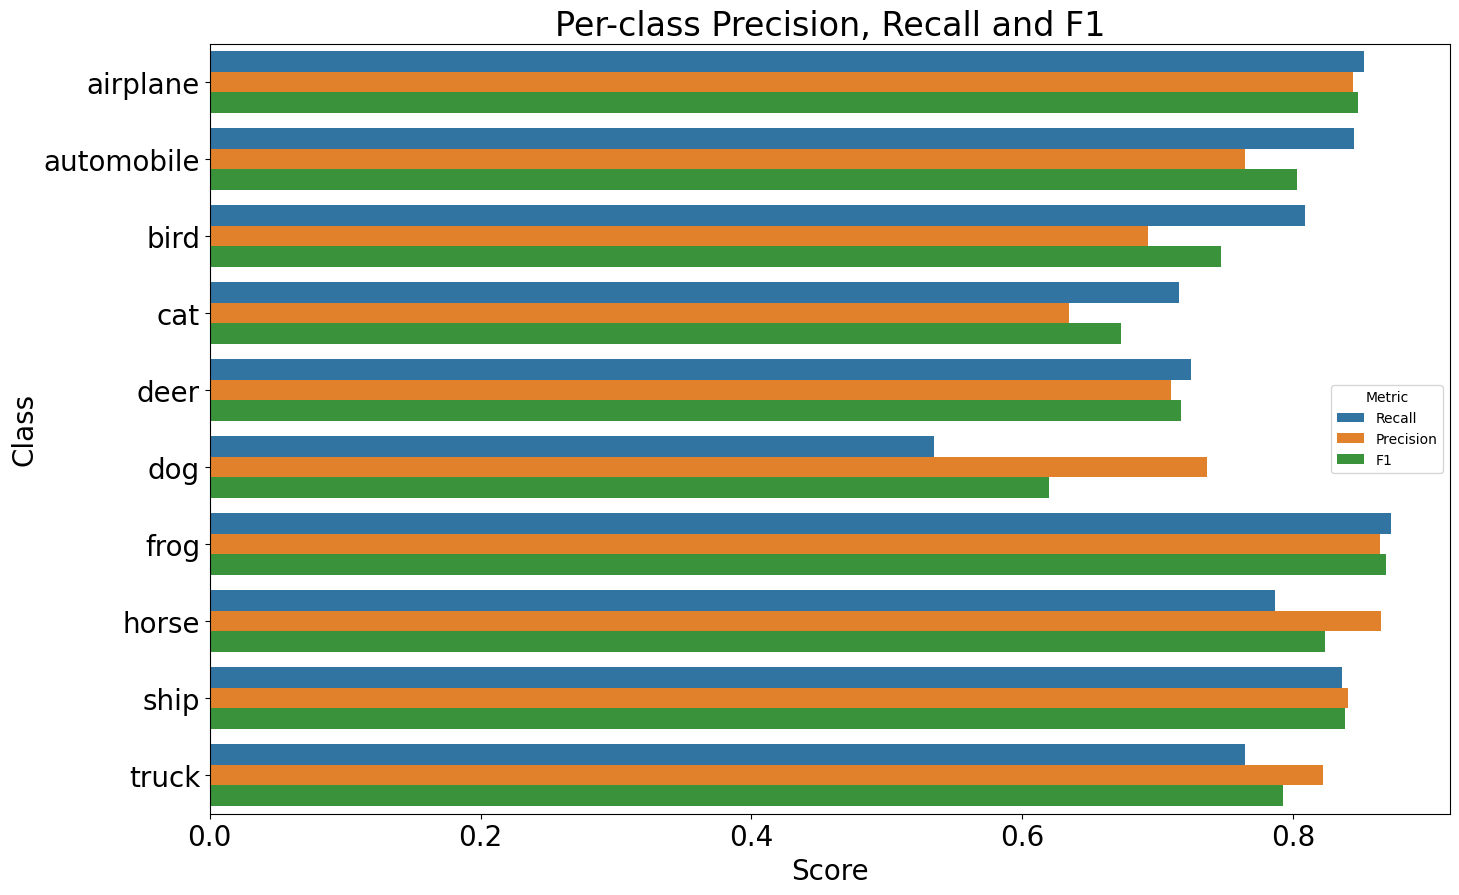

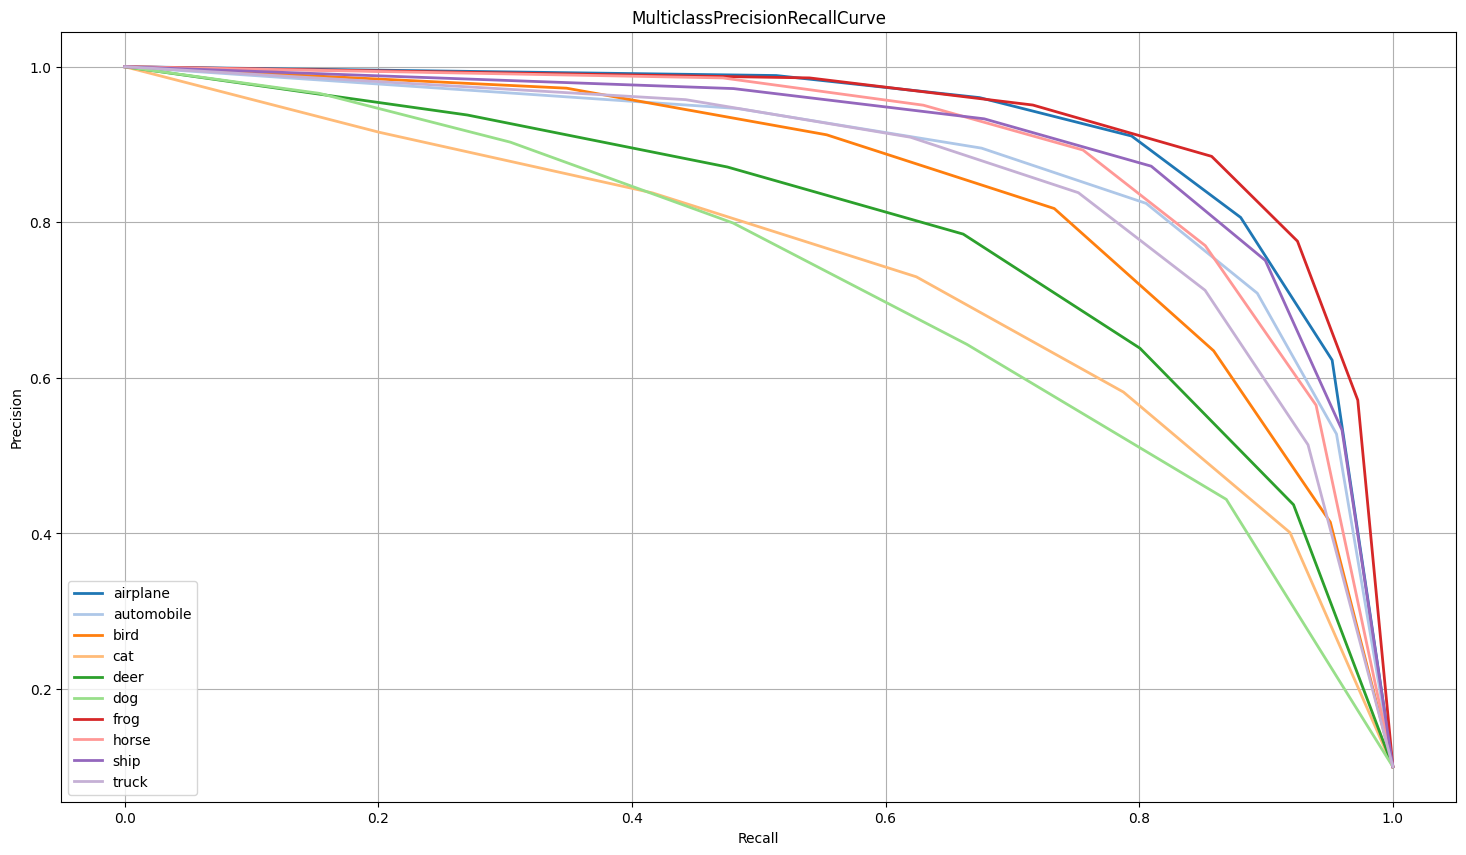

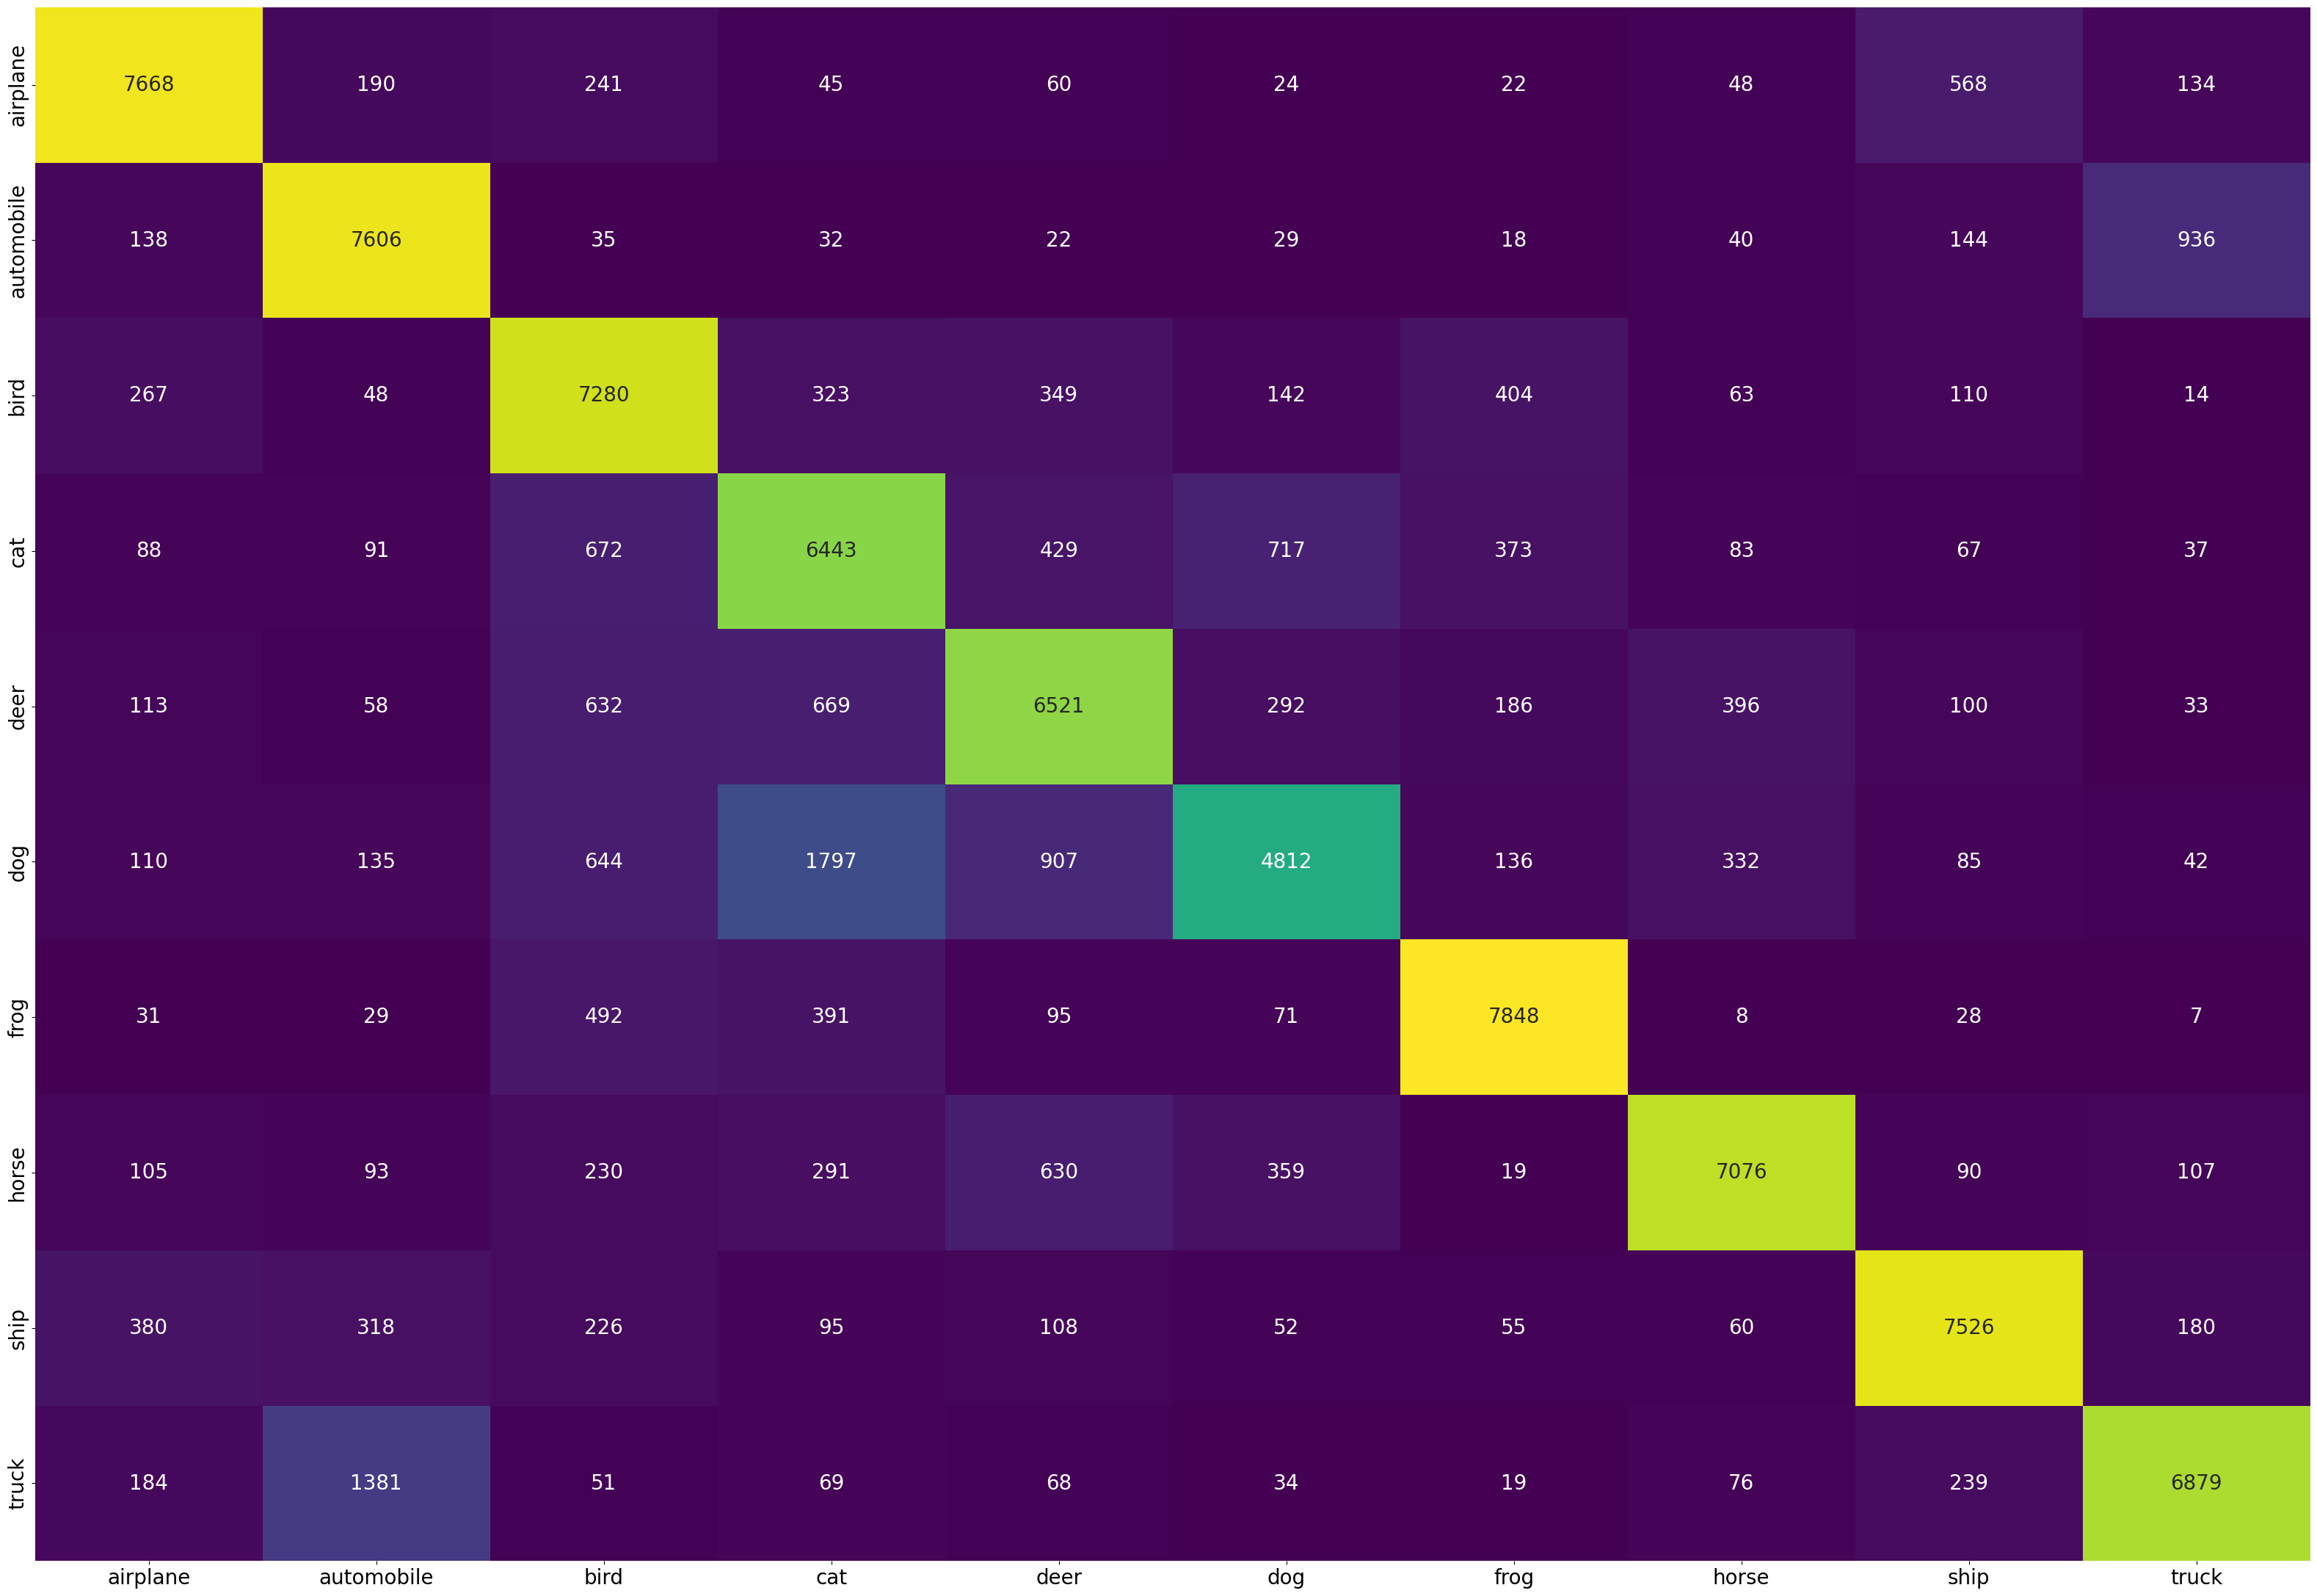

Most common mistakes:
[('dog -> cat: 1797', np.int64(1797)), ('truck -> automobile: 1381', np.int64(1381)), ('automobile -> truck: 936', np.int64(936)), ('dog -> deer: 907', np.int64(907)), ('cat -> dog: 717', np.int64(717))]
Macro Average Precision: 0.8129362463951111
Macro Average Recall: 0.8125
Macro Average F1: 0.8117412328720093
No Average Precision: MulticlassPrecision()
No Average Recall: MulticlassRecall()
No Average F1: MulticlassF1Score()


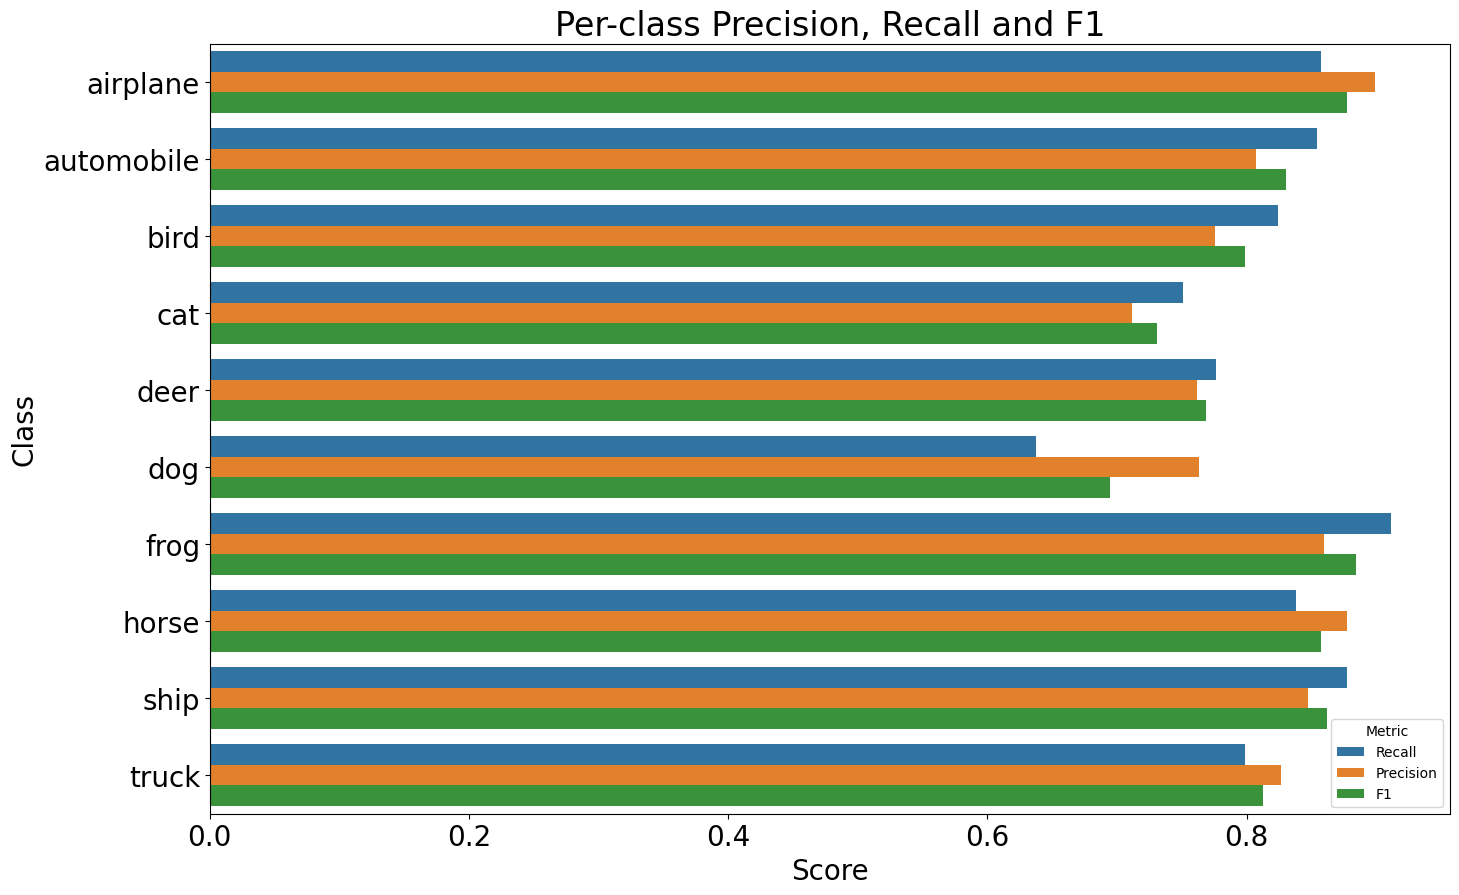

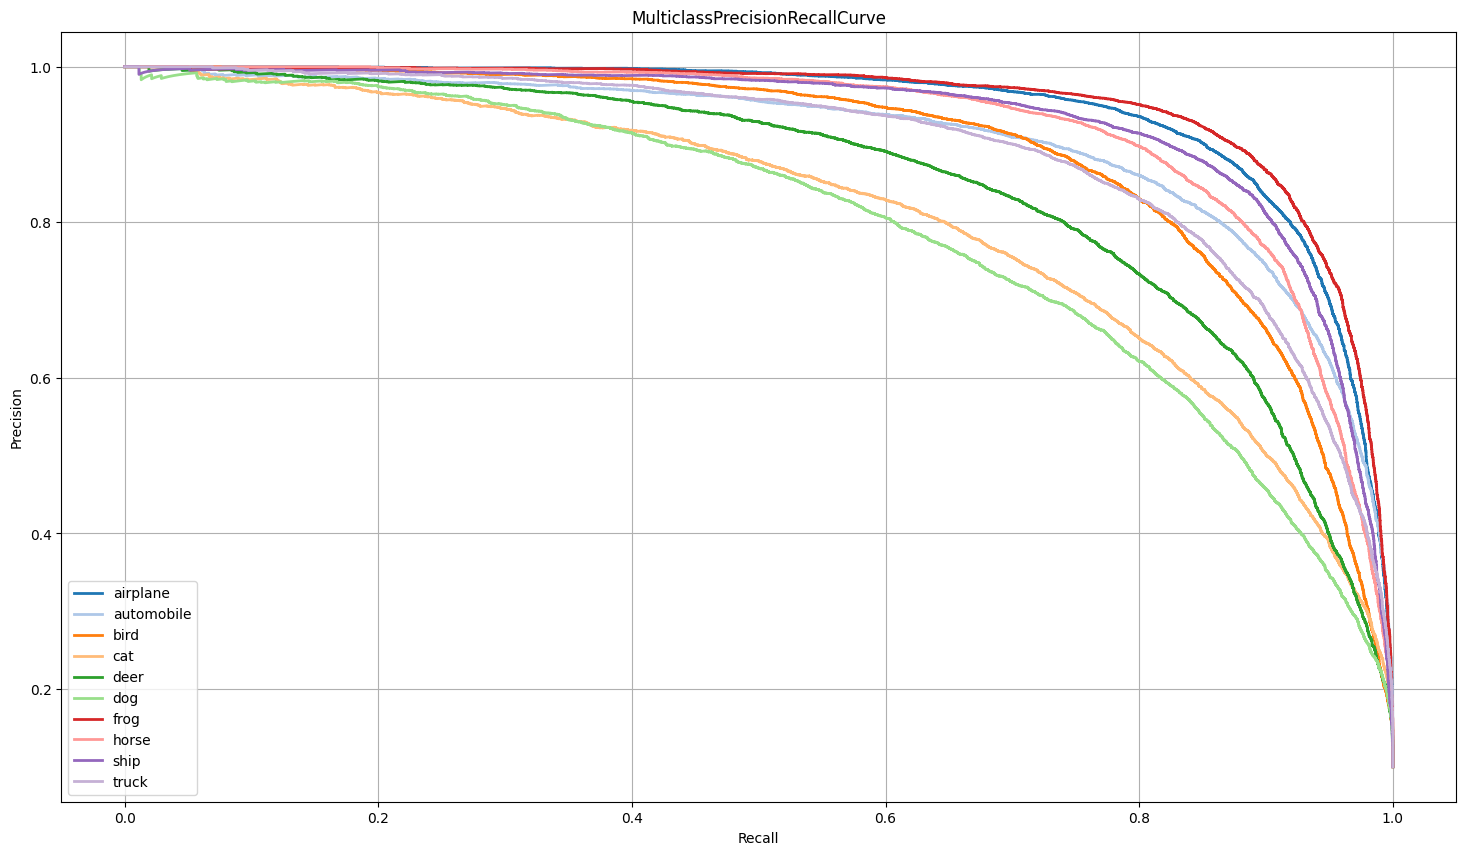

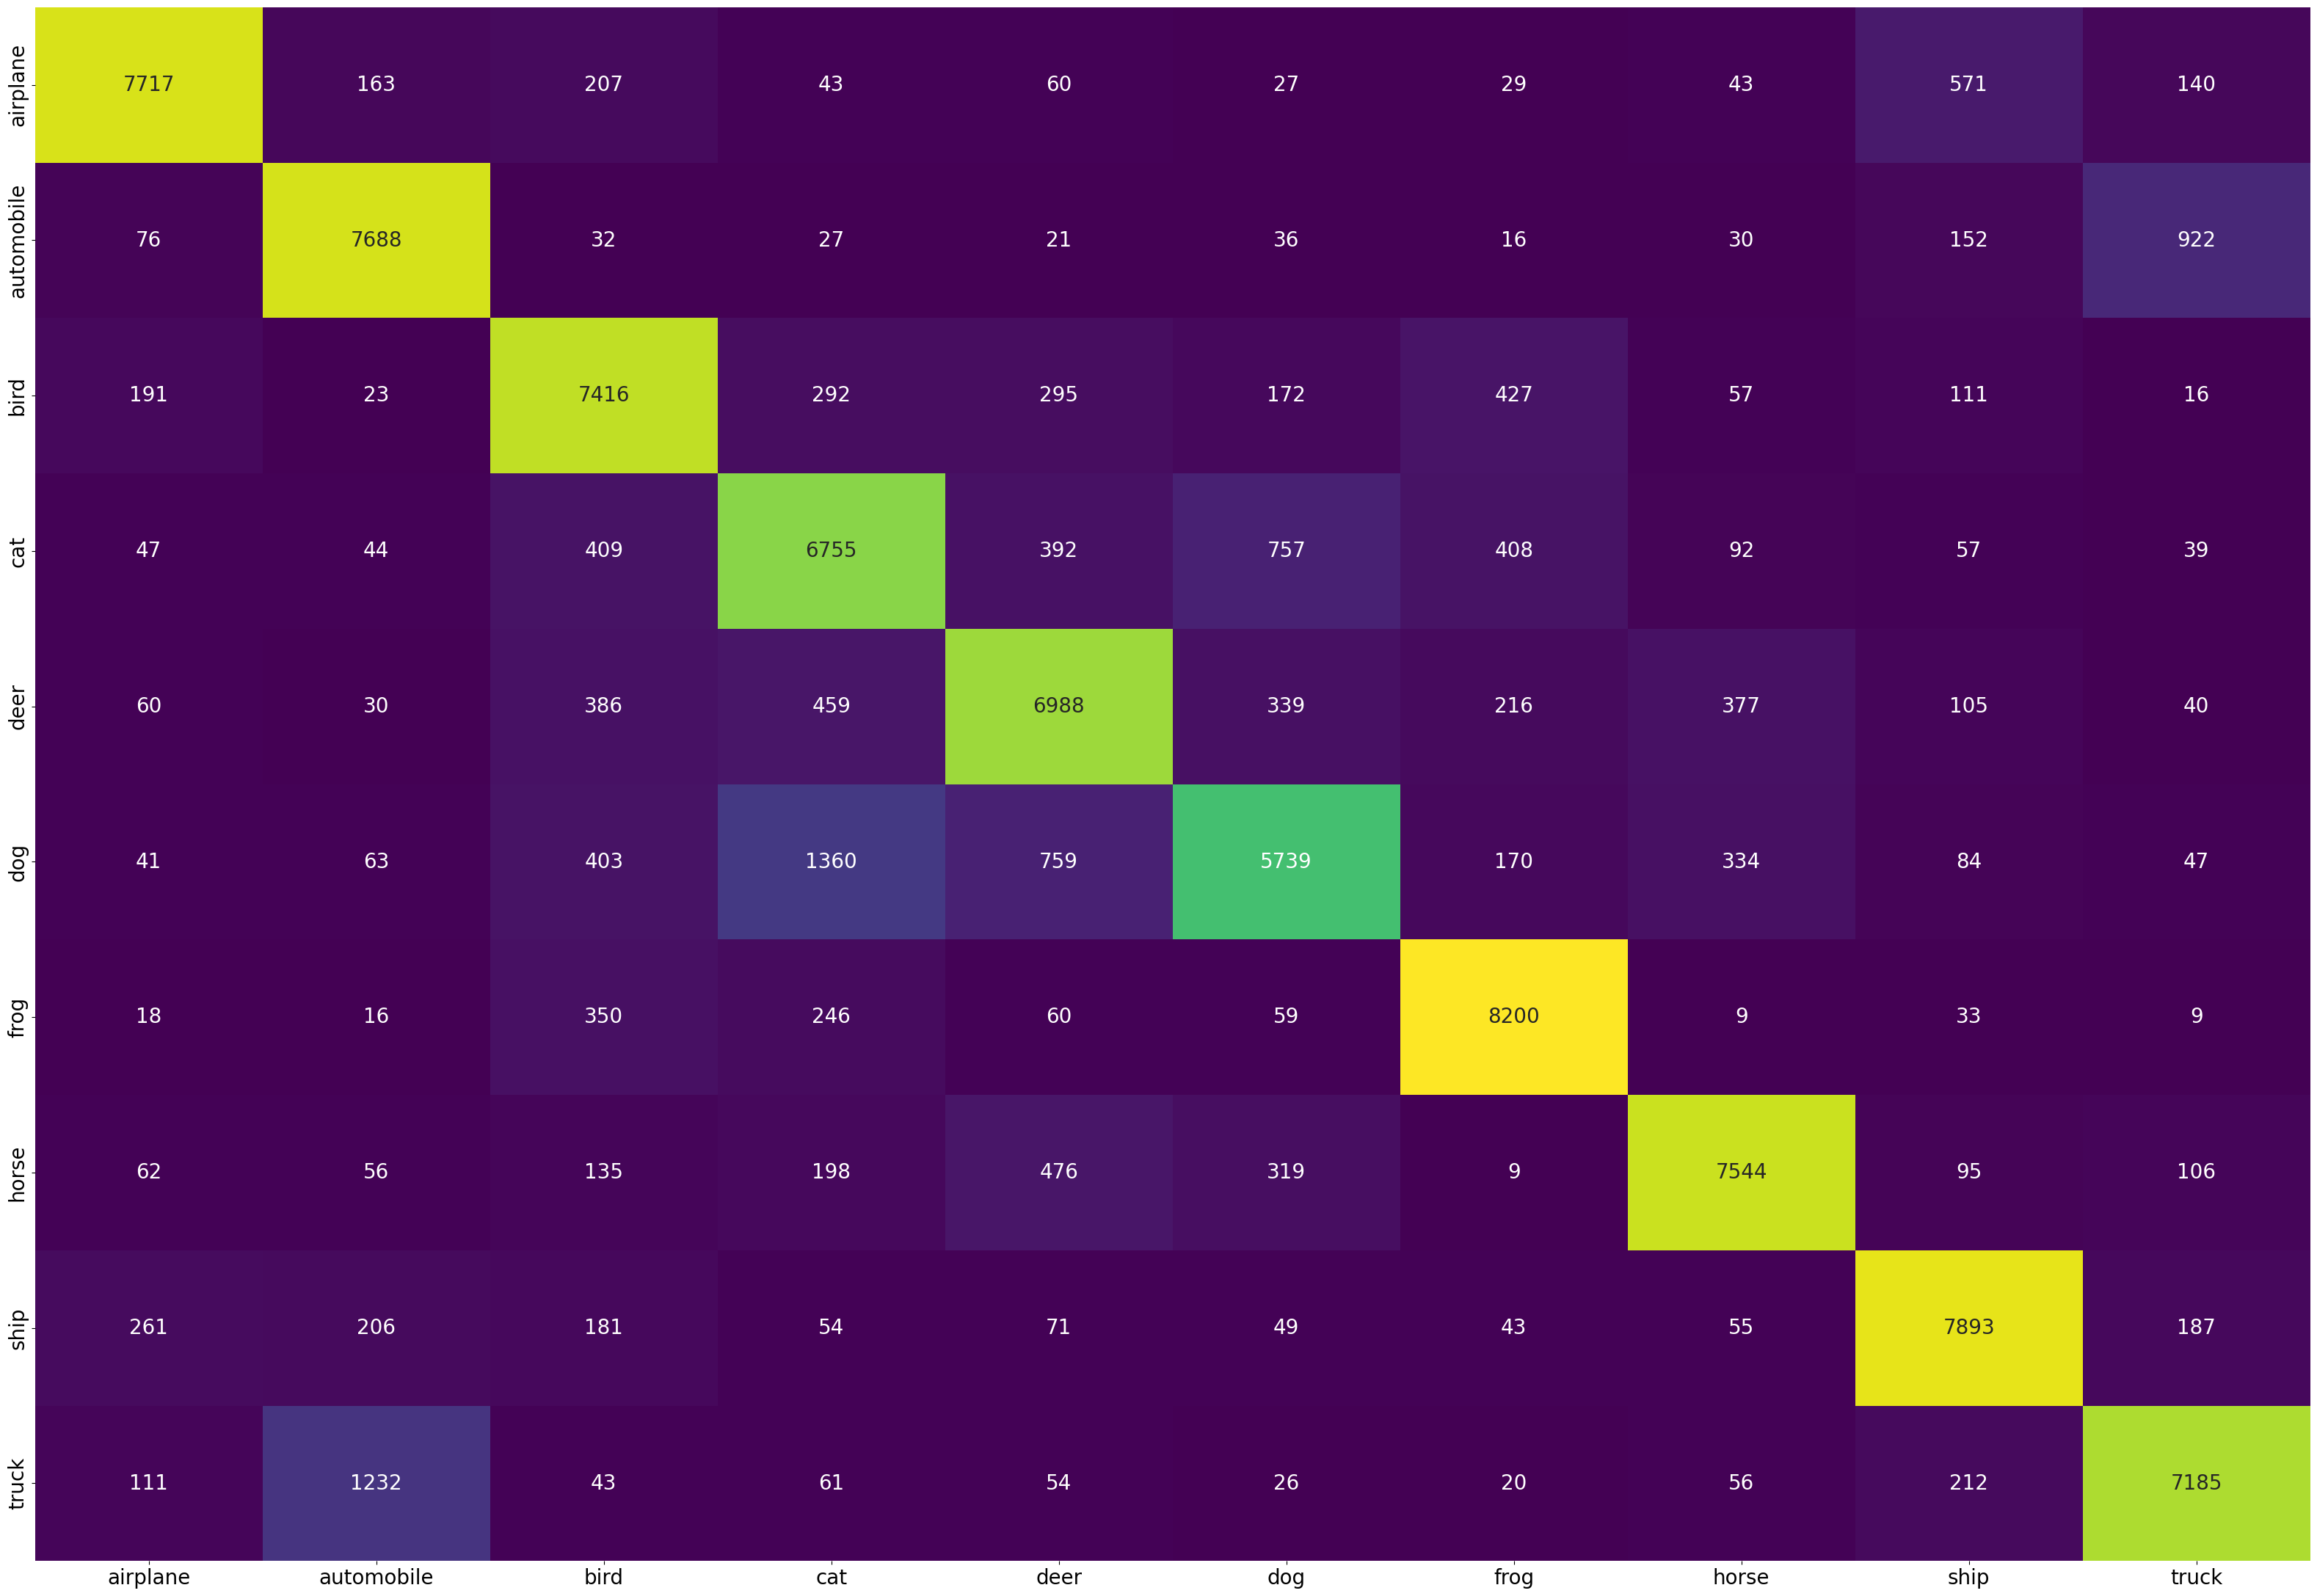

Most common mistakes:
[('dog -> cat: 1360', np.int64(1360)), ('truck -> automobile: 1232', np.int64(1232)), ('automobile -> truck: 922', np.int64(922)), ('dog -> deer: 759', np.int64(759)), ('cat -> dog: 757', np.int64(757))]


In [14]:
show_evaluation(hv_metrics)
show_evaluation(sv_metrics)